# Statistical Foundations of Machine Learning -- project
Authors: Anton Theys, Milan De Schinckel & Luca Iacovella
This notebook contains the project for Statistical Foundations of Machine Learning. Our task was to work on three research questions. We choose the following questions:
1. How do different activation functions compare for binary classification using MLP?
2. What is the impact of class imbalance and different sampling methods on the performance of machine learning algorithms for classification?
3. How can the statistical parity fairness notions be satisfied, and how does affect the performance of a machine learning model?

The cells below install the required Python modules and import what is required for this notebook.

In [2]:
%%capture
%pip install pandas numpy scipy sklearn kaggle tensorflow imblearn aif360 matplotlib seaborn

In [49]:
%%capture

# Data manipulation and math
import pandas as pd
import numpy as np
from scipy.stats import randint, gamma, chi2_contingency, spearmanr
from zipfile import ZipFile
from collections import Counter

# Scikit-learn
from sklearn.datasets import make_circles, make_moons, make_blobs, make_classification, load_breast_cancer, fetch_california_housing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import DecisionBoundaryDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn import FunctionSampler  # to use a idendity sampler
from imblearn.pipeline import make_pipeline

# AIF360
from aif360.datasets import BinaryLabelDataset
from aif360.sklearn.postprocessing import PostProcessingMeta, RejectOptionClassifier, RejectOptionClassifierCV

# Visualization
import matplotlib.pyplot as plt
from matplotlib import tri
import seaborn as sns 


# Supress FutureWarning due from aif360 module
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Suppress the ConvergenceWarning
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Force notebook to align graphs for esthetics
from IPython.core.display import HTML as Center
Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

## Algorithms
In this section, we discuss the used machine learning algorithms.

### 1 Multi layer perceptron
We provide a quick summary of the fundamental concepts
involved with multiple layer perceptron (MLP).


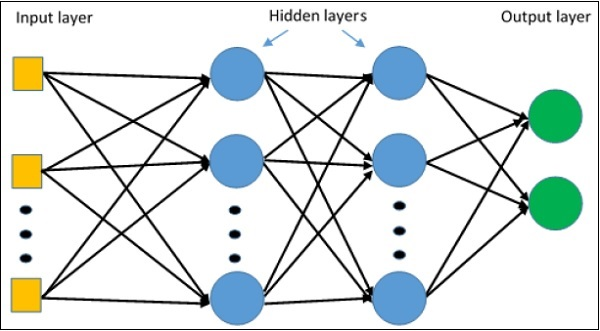


The network consists of neurons which form layers. These layers are
called the input layer, hidden layers and output layer. Often, the
number of neurons in the input layer corresponds to the number of
features. The neurons in this layer simply pass their value to the next
layer. The hidden layers facilitate the magic of neural networks and the
output layer is where the model outputs the solution.

The following equation is the mathematical representation of going from
input to output in a neural network.

$$
\hat{y}= \sigma\left( w^{T}x+b \right)
$$

Here $u$ is the transposed vector of weights, $x$ the value of the
previous neuron and $b$ a bias. $\sigma$ denotes the activation function used in each neuron. This function maps the weighted sum of inputs to the final output of the neuron. The goal of learning in this context is to tune hyperparameters to minimise the sum of all errors
between $\hat{y}$ and target $y$.




Each example is led through the network, this is called
forward-propagation. The model produces an output which, because MLP is a
supervised method, we can compare to the expected output and construct
an average-cost-function. The goal is now to adjust weights and biases
to minimise this function via a process called back-propagation.

$$
AL(w^{T},b) = \frac{1}{m}\sum_{i=1}^{m} L \left( \hat{y}^{(i)}, y^{(i)} \right)
$$


Function $L$ represents the way the loss for each example is calculated.
Commonly used loss-functions are regression mean squared error ($MSE$) for
regression problems and binary cross-entropy or binary classification.


$$
MSE = \left( y_i - \hat{y}_i  \right)^2
$$
$$
\text{Binary cross-entropy} = - \left( y_i \log{ \left( \hat{y}_i \right) } + \left( 1 - y_i \right) \log{ \left( 1 - \hat{y}_i \right)}  \right)
$$

### 2 Linear Support Vector Machines
A linear Support Vector Machine (SVM) is a supervised machine learning algorithm used for binary classification tasks. It is particularly effective when the data can be separated into two classes by a linear boundary.

The goal of a linear SVM is to find the best hyperplane that maximally separates the two classes in the feature space. This hyperplane is defined as a linear decision boundary that assigns labels to new instances based on which side of the hyperplane they fall on.

### 3 Gaussian naive Bayes
The **naive Bayes** classifiers use Bayes theorem to predict the class of a sample. Their main property is that they use an assumpion of independence between features. This is the reason why it is called naive. The naive Bayes models trains from a dataset using the maximum-likelihood probability. Classification of a sample $x$ with features $i$ and target labels $C_j$ can be done by:
$$\argmax_{T_j} \mathbb{P}(T_j) \prod_{i=1}^n \mathbb{P}(x_i \mid T_j)$$

The **Gausian naive Bayes** classifier allows classification of continuous data. This data is assumed to be normally distributed. The conditional probabilities in the formula is given by the normal distribution. For a mean of $\mu_j$ and variance of $\sigma_j^2$ for corresponding features of target class $C_j$ this is:
$$\mathbb{P}(x = n \mid C_j) = \frac 1 {\sigma_j \sqrt{2 \pi}} \exp{\left(- \frac {(n - \mu_j)^2} {2 \sigma_j^2}\right)}$$

## How do different activation functions compare for binary classification using MLP?

Activation functions are a very important part of neural networks. These functions transform the weighted sum of inputs to output. They have great impact on how the network learns during back-propagation and determine what the network can and cannot learn. So the right choice of activation functions is essential for making a good network. There are many options in choosing activation functions. In this study, we compare the 4 best-known ones: identity, sigmoid, tanh and relu. Advantages and disadvantages for each are discussed, and the different functions are compared on syntactic and real world data. A large model with many iterations is used to analyse the convergence behaviour of the activation choice in detail.

To begin, below we introduce the different activation functions which are the subject of this study. There are dozens of activation functions, each with its advantages and disadvantages. For this study, we will focus on the four best known ones. Understanding and comparing their fundamental properties nicely underlines the importance of choosing a good activation function in practice.

### 1 Analysis Activation Function

In [5]:
def visualize_function_and_derivative(func, derivative, label):
    x_positive = np.linspace(0, 10, 1000)
    x_negative = np.linspace(-10, 0, 1000)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].set_title(f'{label} Activation Function', fontweight="bold")
    axes[0].set_xlabel('x')
    axes[0].set_ylabel(f'{label}(x)')
    axes[0].plot(x_negative, func(x_negative), color='blue')
    axes[0].plot(x_positive, func(x_positive), color='blue')
    axes[0].grid(True)  # Enable gridlines
    
    axes[1].set_title(f'{label} Derivative Function', fontweight="bold")
    axes[1].set_xlabel('x')
    axes[1].set_ylabel(f'{label}(x)')
    axes[1].plot(x_negative[1:], derivative(x_negative[1:]), color='blue')
    axes[1].plot(x_positive[:-1], derivative(x_positive[1:]), color='blue')
    axes[1].grid(True)  # Enable gridlines
    axes[1].set_ylim(-0.1, 1.1)
    
    
    plt.tight_layout()
    plt.show()

#### 1.1 Linear activation

In [6]:
def linear(x):
    return x

In [7]:
def linear_derivative(x):
    return np.ones_like(x)

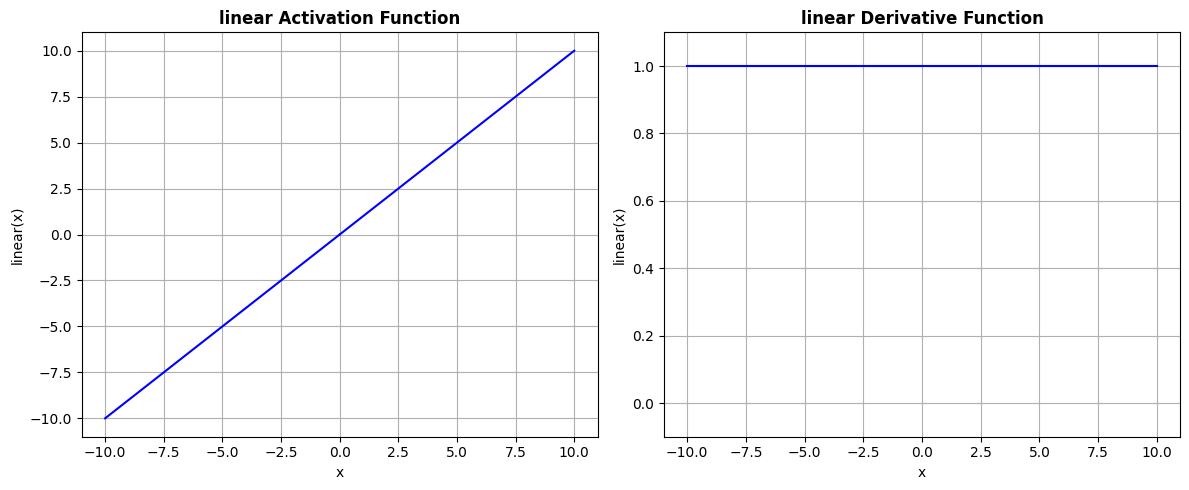

In [8]:
visualize_function_and_derivative(linear, linear_derivative, "linear")

The linear activation function also known as the identity function is probably the most easy to understand function, it just maps the input to itself so has no effect on the weighted sum of the input. 

$$
f \left( x \right) = x
$$

#### 1.2 Sigmoid activation

In [9]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [10]:
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

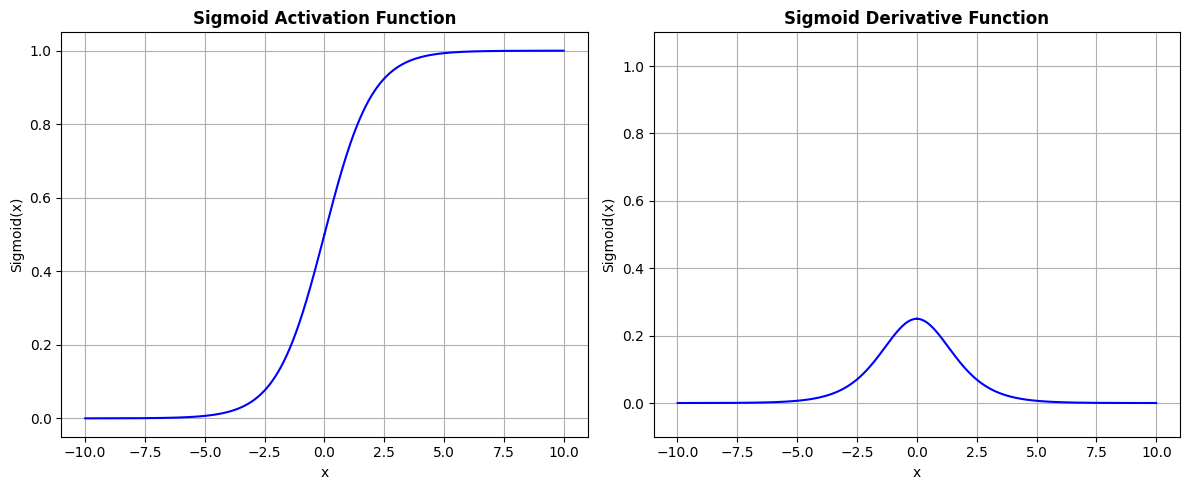

In [11]:
visualize_function_and_derivative(sigmoid, sigmoid_derivative, "Sigmoid")

The sigmoid function compresses to any real value input to a $[0, 1]$ range. The larger the input becomes, the closer the output approaches 1.  The ouput approaches 0 when the input becomes smaller. We can clearly see that the gradient for this function is significant only within the [-3, 3] range. Outside this range, the gradient is zer small and thus it is more difficult to learn. This will be discussed in detail in what follows.

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

#### 1.3 Tanh activation

In [12]:
def tanh(x):
    return np.tanh(x)

In [13]:
def tanh_derivative(x):
    return 1 - np.tanh(x)**2

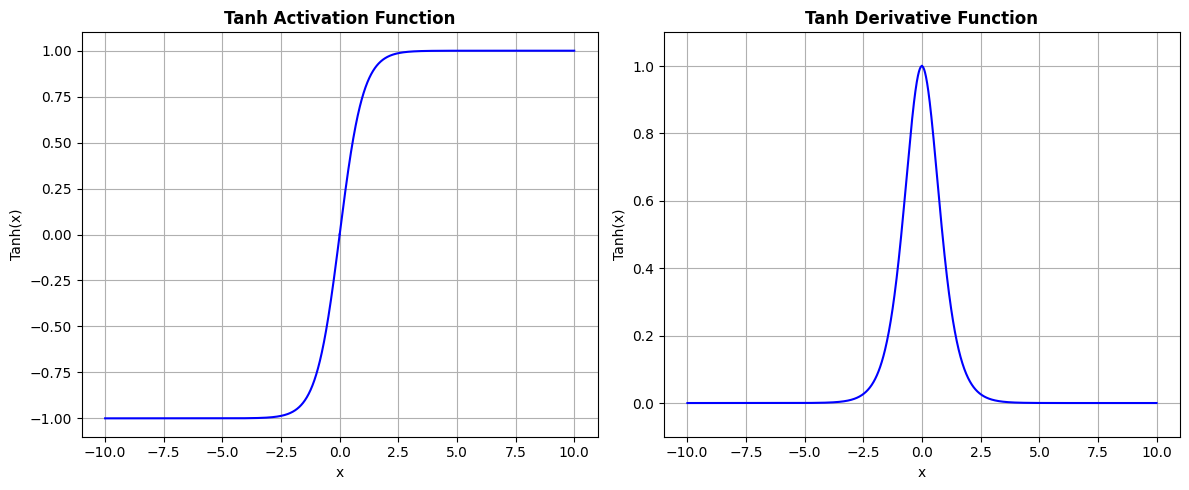

In [14]:
visualize_function_and_derivative(tanh, tanh_derivative, "Tanh")

The behaviour of the tanh activation function has mostly the same characteristics as the sigmoid function. The most important difference is than when using tanh the input is mapped to a $[-1, 1]$ range. This also allows negative activations which helps in finding complex mappings. At first glance, the van tanh and sigmoid function are very similar, but there are some important differences. The tanh function has steeper gradients around the origin which allows for larger steps in the learning process. Tanh is also sensitive to the vanishing gradient problem, but slightly less than the sigmoid.

$$
f(x) = \frac{(e^x - e^{-x})}{(e^x + e^{-x})}
$$


#### 1.4 RELU activation

In [15]:
def relu(x):
    return np.where(x > 0, x, 0)


In [16]:
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

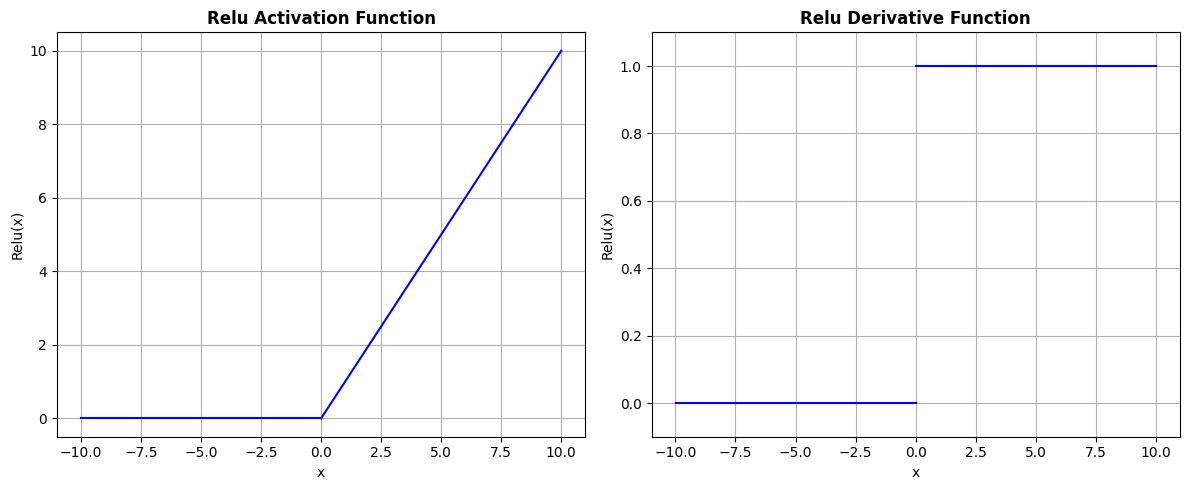

In [17]:
visualize_function_and_derivative(relu, relu_derivative, "Relu")

Rectified linear unit or simply put RELU is special because not all neurons in the network are activated when using this function. More precisely, neurons will be activated only for outputs greater than 0. This function combines the speed of the identity function with the introduction of non-linearity. This allows faster computation compared to sigmoid and tanh.

$$
f(x) = max(0, x)
$$

### 2 Comparison using synthetic data

In [18]:
# Train all models with different activation functions on the same data 
# Output the lust of all models 
def get_trained_model_list(x_train, y_train):
    params = {
        'hidden_layer_sizes': (150, 200),
        'random_state' : 20, # Allow reproducability
        'max_iter' : 3000, # Allows analysis on convergence
        'n_iter_no_change' : 3000, # Allows analysis on convergence
        'early_stopping' : True # Necessary for viz of validation 
    }
    MLP_iden_model = MLPClassifier(**params, activation='identity').fit(x_train, y_train)
    MLP_logi_model = MLPClassifier(**params, activation='logistic').fit(x_train, y_train)
    MLP_tanh_model = MLPClassifier(**params, activation='tanh').fit(x_train, y_train)
    MLP_relu_model = MLPClassifier(**params, activation='relu').fit(x_train, y_train)
    return MLP_iden_model, MLP_logi_model, MLP_tanh_model, MLP_relu_model

In [19]:
# Visualizes decision boundaries for a list of trained models
def visualize_decision_boundaries(model_list, x_train):
    figure, ax = plt.subplots(2, 2, figsize=(9.84,9.84))
    ax = ax.T.flatten()
    i = 0
    
    for classifier in model_list:
        
        disp = DecisionBoundaryDisplay.from_estimator(classifier, 
                                                      x_train, 
                                                      response_method="predict",
                                                      xlabel="x_1", ylabel="x_2",
                                                      alpha=0.5, 
                                                      cmap=plt.cm.coolwarm,
                                                      ax=ax[i])
        disp.ax_.scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolor="k", cmap=plt.cm.coolwarm)
        disp.ax_.set_title(f"MLP using {classifier.activation}, MSE in sample: {round(classifier.loss_, 3)}")
        i += 1
        
    plt.show()  
    

In [20]:
# visualize validation and loss scores for a list of trained models
def visualize_combined_plots(model_list):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Visualize validation scores
    axes[0].set_title('Validation Scores During Training')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Accuracy')
    for classifier in model_list:
        validation_scores = classifier.validation_scores_
        tag = classifier.activation
        axes[0].plot(validation_scores, label=tag)
    axes[0].legend()

    # Visualize loss curve
    axes[1].set_title('Loss Curve During Training')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Loss')
    for classifier in model_list:
        loss_curve = classifier.loss_curve_
        tag = classifier.activation
        axes[1].plot(loss_curve, label=tag)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


#### 2.1 Circle-like data

In [21]:
# Generate 2d classification dataset -- Circle like
X, y = make_circles(n_samples=200, shuffle=True,
                    noise=0.1, random_state=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4)
trained_models = get_trained_model_list(x_train, y_train)



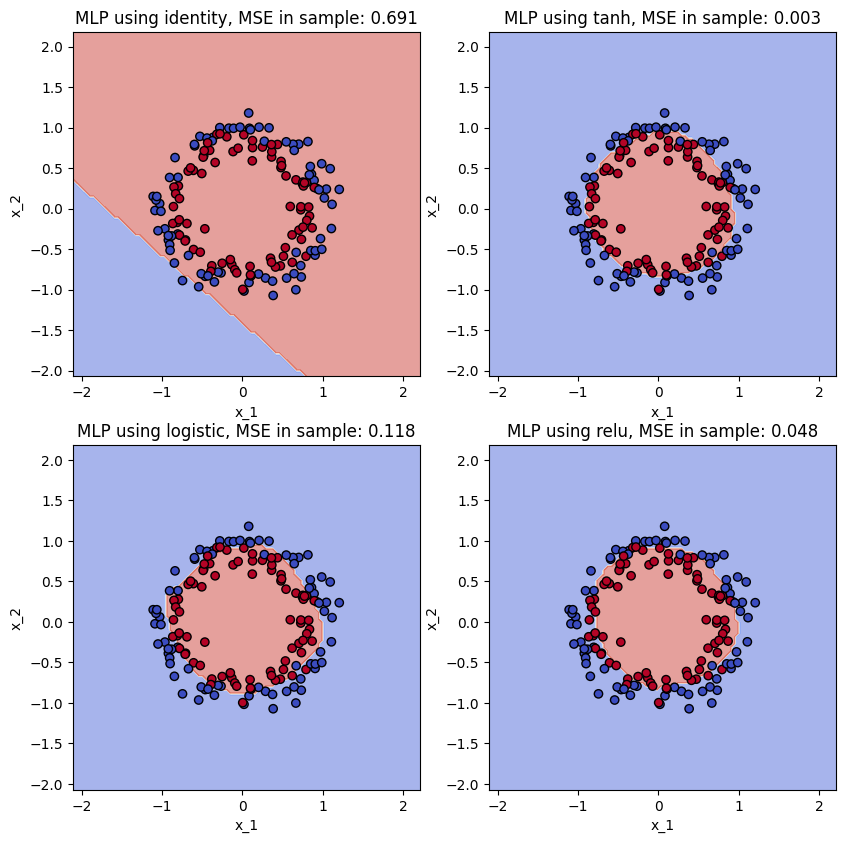

In [22]:
visualize_decision_boundaries(trained_models, x_train)

The synthetic data consists of an inner, predominantly red labelled, and an outer, predominantly blue labelled set of data points. The figure above visualises the discussion boundaries of the trained model for each activation function used. We see that only when using the identity function the model unable to fit the data points. Of course, this is hardly surprising since this data is not linearly separatable and this activation function can only obtain a linear function.

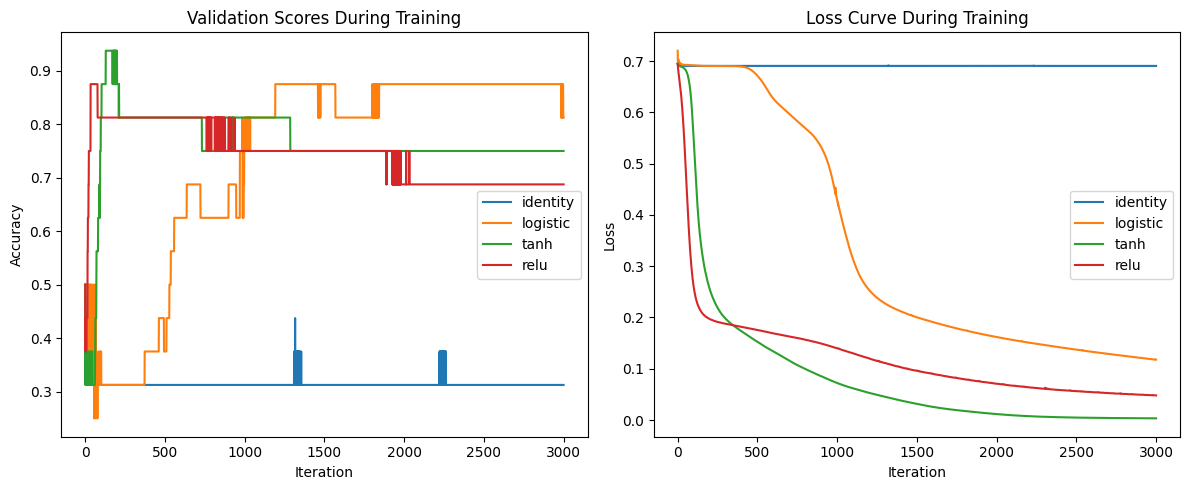

In [23]:
visualize_combined_plots(trained_models)

In line with the above findings on the inadequacy of the identity function, we see in the loss curve visualisation that this model is unable to reduce the loss. What is interesting here is that using the logistic function, it takes significantly more time to converge compared to tanh and relu. Why? The answer lies in the properties of this function. As discussed in the introduction, back-propagation and thus learning uses derivations to facilitate gradient descent. The gradients for inputs outside the [-4, 4] range are near 0. Multiple layers in a network (like the one used here) cause the convergence of the partial derivation of the loss function to 0. The weights of the neurons change only slightly as the gradient gets smaller which slows down learning enormously or sometimes even makes it impossible. This is called the vanishing gradient problem.

$$
\frac{d}{dx}\sigma\left(x  \right) = \sigma\left( x \right)\left(1 - \sigma\left( x \right) \right)
$$

But then, why not just forget about the existence of the sigmoid function? Because this function also has some good uses. Since its output always lies between 0 and 1, this function can be used in the final layer to represent probabilities. There is also a computationally interesting property in the derivation of this function. The derivative of the sigmoid function can be calculated using the formula above. The necessary $\sigma\left( x \right)$ was already calculated during feedforward and so a lot of time can be saved for this calculation.

Note: the tanh function also has this property.

#### 2.2 Interlocked cresent like data

In [24]:
# generate 2d classification dataset - Moon like
X, y = make_moons(n_samples=500, shuffle=True,
                  noise=0.15, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4)
trained_models = get_trained_model_list(x_train, y_train)

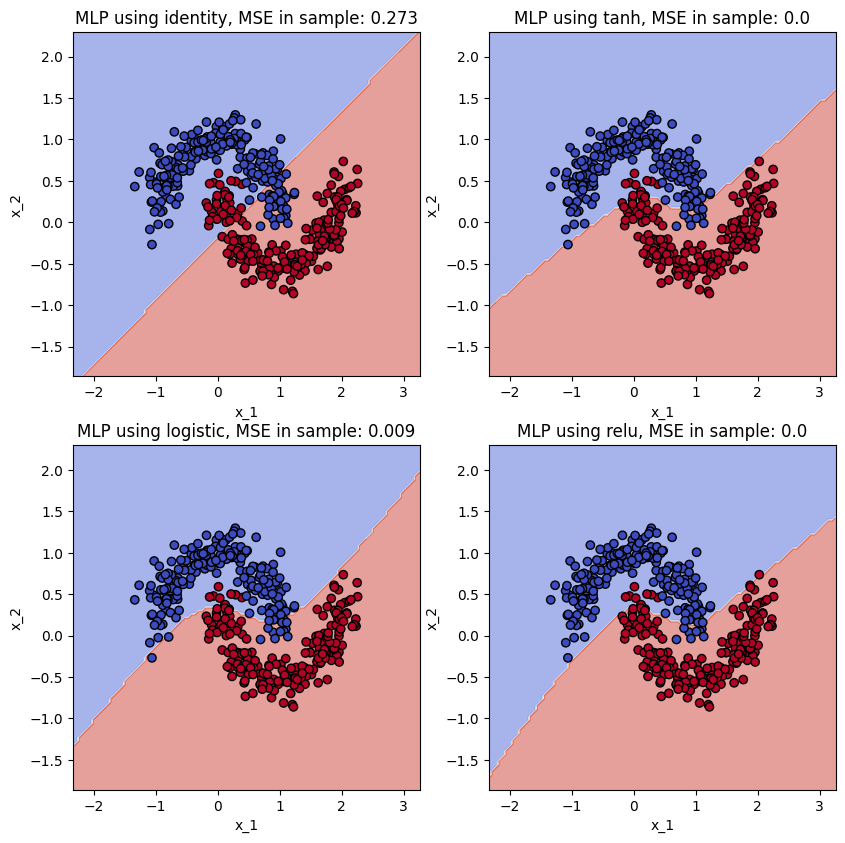

In [25]:
visualize_decision_boundaries(trained_models, x_train)

This data consists of 2 interlocking semi-circles. Both predominantly consisting of one type of label. You can clearly see that a strongly varying function is needed to classify this data correctly. Like the data discussed above, this data is also not linearly classifiable so a model with the identity function does not help us here.

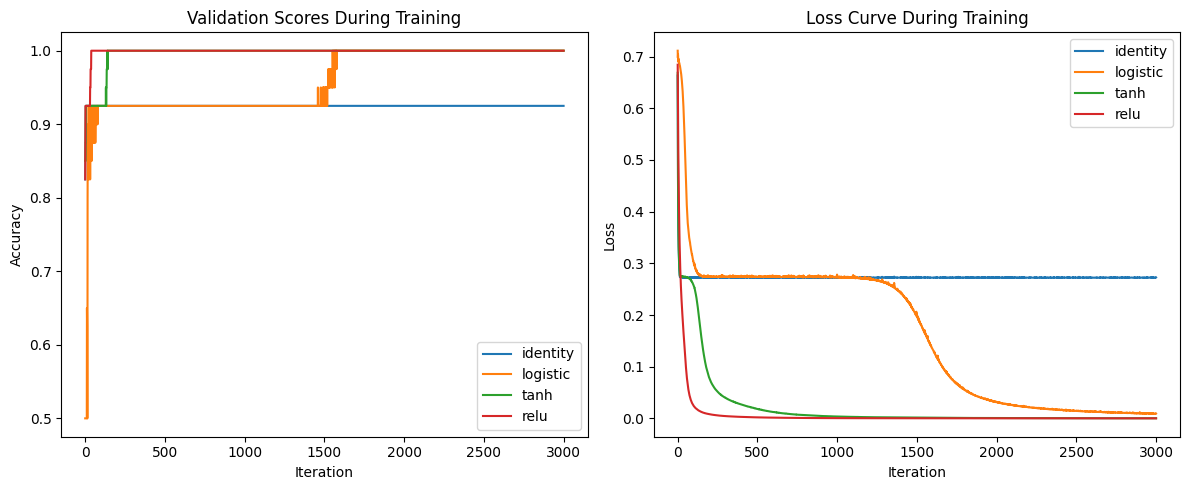

In [26]:
visualize_combined_plots(trained_models)

Again, the slow convergence of the sigmoid function is immediately noticeable. This is another case of the vanishing gradient problem here. What is also striking is that both here and in the previous example, tanh and relu both converge quickly. Why do these functions converge so much faster than the sigmoid function? This can mainly be attributed to the fact that both tanh and relu have much steeper gradients. Because of these steeper gradients, larger steps can be taken during backpropagation during gradient descent and learning is faster. This also gives a huge advantage because this way the gradient is harder to disappear.

### 2.3 Linear seperable data

In [27]:
#reinitialze training function with different params
def get_trained_model_list(x_train, y_train):
    params = {
        #because convergence happens very fast there is
        #no need to force the network into overfitting 
        #this allows us to make sense of the visualizations
        'hidden_layer_sizes': (150, 200),
        'random_state' : 20,
        'early_stopping' : True
    }
    MLP_iden_model = MLPClassifier(**params, activation='identity').fit(x_train, y_train)
    MLP_logi_model = MLPClassifier(**params, activation='logistic').fit(x_train, y_train)
    MLP_tanh_model = MLPClassifier(**params, activation='tanh').fit(x_train, y_train)
    MLP_relu_model = MLPClassifier(**params, activation='relu').fit(x_train, y_train)
    return MLP_iden_model, MLP_logi_model, MLP_tanh_model, MLP_relu_model

In [28]:
# Generate 2d classification dataset -linear classifieble
X, y = make_blobs(n_samples=500, centers=2, n_features=2, random_state=23)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4)
trained_models = get_trained_model_list(x_train, y_train)

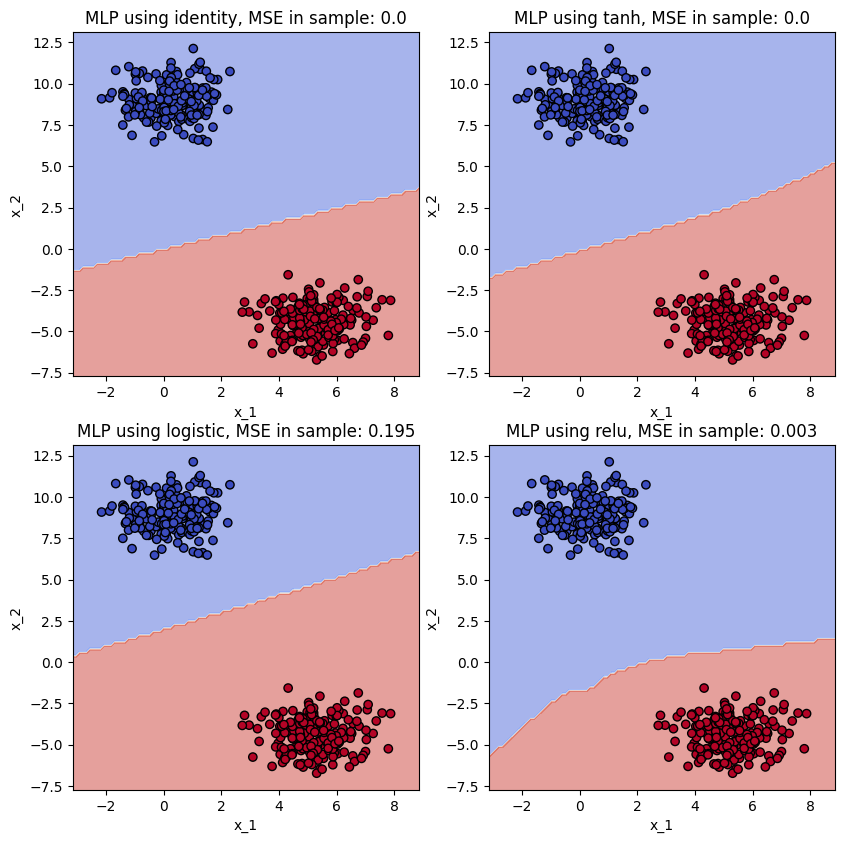

In [29]:
visualize_decision_boundaries(trained_models, x_train)

For the final synthetic experiment, data points with the same labels are clustered together so that the 2 labels are distinguishable using a linear function. As expected, all models are able to fit this data.

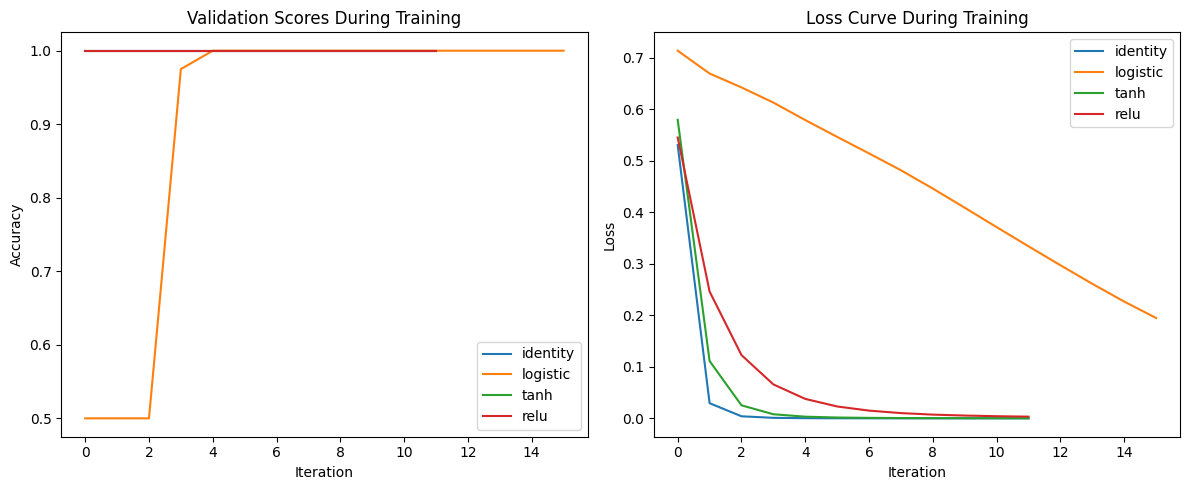

In [30]:
visualize_combined_plots(trained_models)

Without much surprise, we see that 3 of the four models converge perfectly after just a few iterations. Only the sigmoid function, which can only take small steps during backpropagation, takes longer to converge. In the context of linear classifiable data, it is interesting to choose the identity function because it provides significantly less complexity. This makes results easier to interpret compared to models using sigmoid, tanh or relu. The linear property allows insight into the relationship between input and output more easily. It should be noted, however, that this model is therefore not a "white box". The interpretability of the model is still closely related to its depth and complexity.

### 3 Comparison using real-world data

Having established some characteristic properties of the different activation functions on syntetic data, we now look at real world data in the context of a kaggle dataset. This dataset consists of 569 cell nuclei described by 10 features each. The goal is binary classification into classes M (malignant) and B (benign). In the following, the data is examined and preprocessed.

In [31]:
def get_trained_model_list_real(x_train, y_train):
    params = {
        #'hidden_layer_sizes': (200, 200),
        'hidden_layer_sizes': (150, 200),
        'random_state' : 20,
        'early_stopping' : True
    }
    MLP_iden_model = MLPClassifier(**params, activation='identity').fit(x_train, y_train)
    MLP_logi_model = MLPClassifier(**params, activation='logistic').fit(x_train, y_train)
    MLP_tanh_model = MLPClassifier(**params, activation='tanh').fit(x_train, y_train)
    MLP_relu_model = MLPClassifier(**params, activation='relu').fit(x_train, y_train)
    return MLP_iden_model, MLP_logi_model, MLP_tanh_model, MLP_relu_model

In [32]:
# pretty print the score for each model
def get_acurracy(trained_models, x_test, y_test):
    for classifier in trained_models:
        predictions = classifier.predict(x_test)
        print(f"Out of sample error {classifier.activation}: {mean_squared_error(y_test, predictions)}")

In [33]:
data = load_breast_cancer()
features = data['data']
labels = data['target']

In [34]:
df = pd.DataFrame(features, columns = data['feature_names'])
df.insert(loc=0, column='labels', value=labels)
df.head()

labels  mean radius  mean texture  mean perimeter  mean area  \
0       0        17.99         10.38          122.80     1001.0   
1       0        20.57         17.77          132.90     1326.0   
2       0        19.69         21.25          130.00     1203.0   
3       0        11.42         20.38           77.58      386.1   
4       0        20.29         14.34          135.10     1297.0   

   mean smoothness  mean compactness  mean concavity  mean concave points  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   mean symmetry  ...  worst radius  worst texture  worst perimeter  \
0         0.2419  ...         25.38          17.33           184.60   
1         0.1812  ...         24.99          23.41           158.80   
2         0.2069  ...         23.57          25.53           152.50   
3         0.2597  ...         14.91          26.50            98.87   
4         0.1809  ...         22.54          16.67           152.20   

   worst area  worst smoothness  worst compactness  worst concavity  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   worst concave points  worst symmetry  worst fractal dimension  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 31 columns]

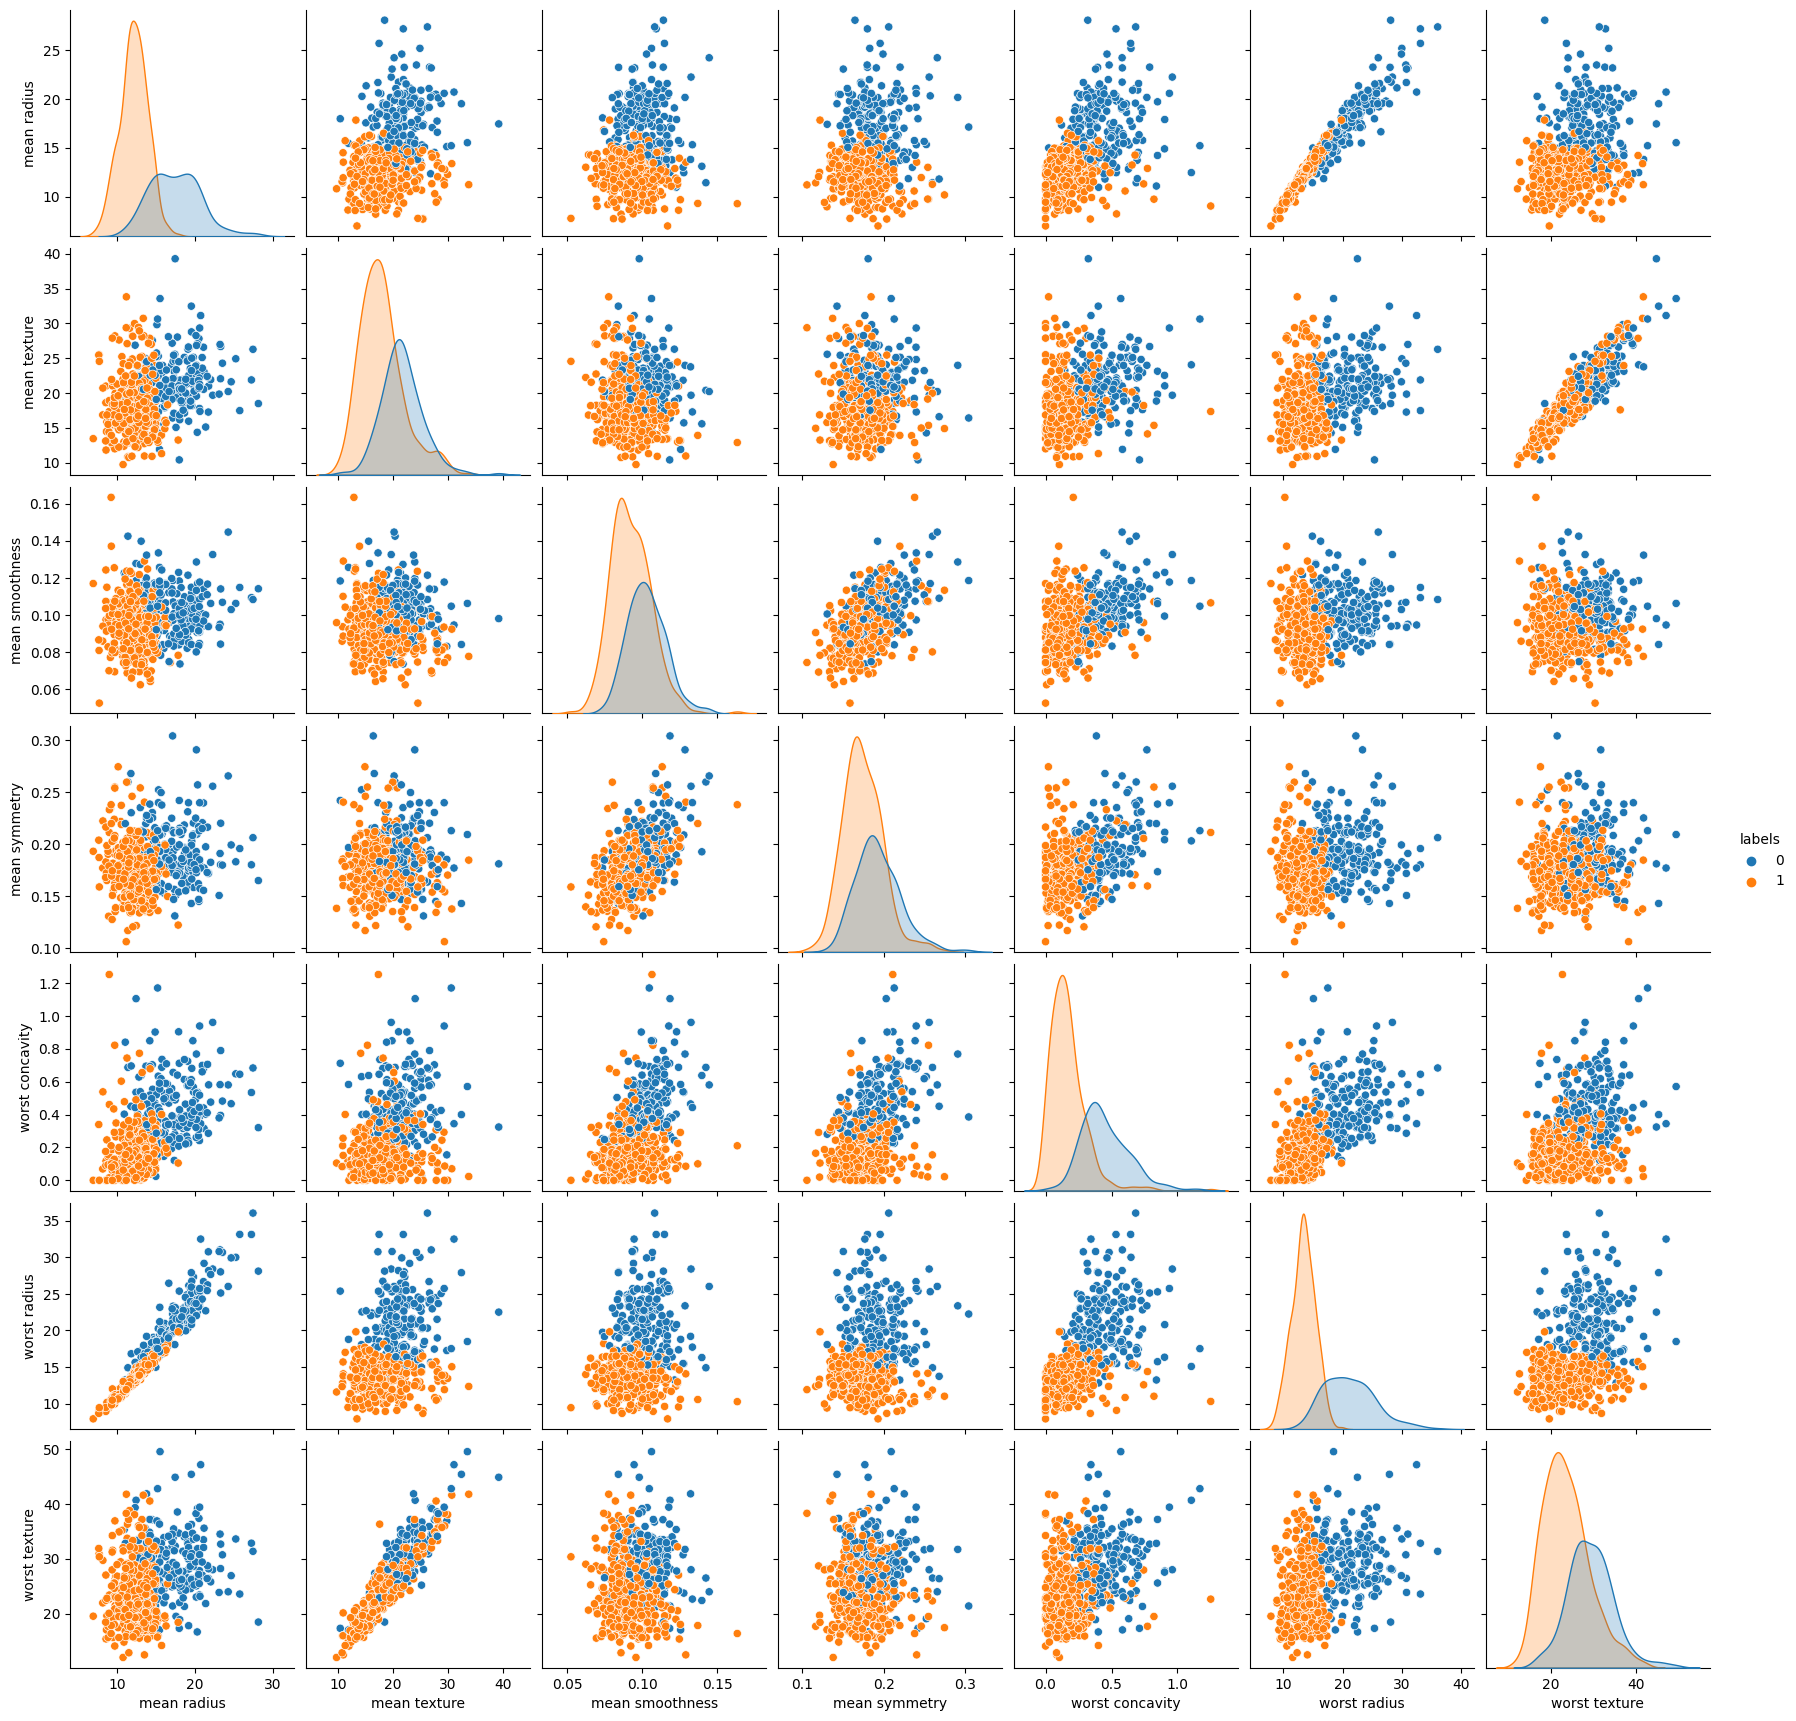

In [35]:
sns.pairplot( data=df, vars= ("mean radius", "mean texture", "mean smoothness", "mean symmetry", "worst concavity", "worst radius", "worst texture"), hue='labels' )

The visualisation above gives a nice first impression on the correlation between the features and the target. A linear split is clearly possible for certain features. This sounds like a job for the identity activation feature.

In [36]:
df = df.drop(['labels'], axis = 1)

In [37]:
df.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       mean symmetry  mean fractal dimension  ...  worst radius  \
count     569.000000              569.000000  ...    569.000000   
mean        0.181162                0.062798  ...     16.269190   
std         0.027414                0.007060  ...      4.833242   
min         0.106000                0.049960  ...      7.930000   
25%         0.161900                0.057700  ...     13.010000   
50%         0.179200                0.061540  ...     14.970000   
75%         0.195700                0.066120  ...     18.790000   
max         0.304000                0.097440  ...     36.040000   

       worst texture  worst perimeter   worst area  worst smoothness  \
count     569.000000       569.000000   569.000000        569.000000   
mean       25.677223       107.261213   880.583128          0.132369   
std         6.146258        33.602542   569.356993          0.022832   
min        12.020000        50.410000   185.200000          0.071170   
25%        21.080000        84.110000   515.300000          0.116600   
50%        25.410000        97.660000   686.500000          0.131300   
75%        29.720000       125.400000  1084.000000          0.146000   
max        49.540000       251.200000  4254.000000          0.222600   

       worst compactness  worst concavity  worst concave points  \
count         569.000000       569.000000            569.000000   
mean            0.254265         0.272188              0.114606   
std             0.157336         0.208624              0.065732   
min             0.027290         0.000000              0.000000   
25%             0.147200         0.114500              0.064930   
50%             0.211900         0.226700              0.099930   
75%             0.339100         0.382900              0.161400   
max             1.058000         1.252000              0.291000   

       worst symmetry  worst fractal dimension  
count      569.000000               569.000000  
mean         0.290076                 0.083946  
std          0.061867                 0.018061  
min          0.156500                 0.055040  
25%          0.250400                 0.071460  
50%          0.282200                 0.080040  
75%          0.317900                 0.092080  
max          0.663800                 0.207500  

[8 rows x 30 columns]

We observe high variation for some features in the dataset. To ensure efficient learning convergence and prevent biased weight updates, we apply standarisation.

In [38]:
#scale all features to counter high variance
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
df = pd.DataFrame(scaled, columns = data['feature_names'])
df.describe()

mean radius  mean texture  mean perimeter     mean area  \
count  5.690000e+02  5.690000e+02    5.690000e+02  5.690000e+02   
mean  -3.153111e-15 -6.568462e-15   -6.993039e-16 -8.553985e-16   
std    1.000880e+00  1.000880e+00    1.000880e+00  1.000880e+00   
min   -2.029648e+00 -2.229249e+00   -1.984504e+00 -1.454443e+00   
25%   -6.893853e-01 -7.259631e-01   -6.919555e-01 -6.671955e-01   
50%   -2.150816e-01 -1.046362e-01   -2.359800e-01 -2.951869e-01   
75%    4.693926e-01  5.841756e-01    4.996769e-01  3.635073e-01   
max    3.971288e+00  4.651889e+00    3.976130e+00  5.250529e+00   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count     5.690000e+02      5.690000e+02    5.690000e+02         5.690000e+02   
mean      6.081447e-15     -1.136369e-15   -2.997017e-16         1.023981e-15   
std       1.000880e+00      1.000880e+00    1.000880e+00         1.000880e+00   
min      -3.112085e+00     -1.610136e+00   -1.114873e+00        -1.261820e+00   
25%      -7.109628e-01     -7.470860e-01   -7.437479e-01        -7.379438e-01   
50%      -3.489108e-02     -2.219405e-01   -3.422399e-01        -3.977212e-01   
75%       6.361990e-01      4.938569e-01    5.260619e-01         6.469351e-01   
max       4.770911e+00      4.568425e+00    4.243589e+00         3.927930e+00   

       mean symmetry  mean fractal dimension  ...  worst radius  \
count   5.690000e+02            5.690000e+02  ...  5.690000e+02   
mean   -1.860648e-15           -1.504752e-15  ... -2.297713e-15   
std     1.000880e+00            1.000880e+00  ...  1.000880e+00   
min    -2.744117e+00           -1.819865e+00  ... -1.726901e+00   
25%    -7.032397e-01           -7.226392e-01  ... -6.749213e-01   
50%    -7.162650e-02           -1.782793e-01  ... -2.690395e-01   
75%     5.307792e-01            4.709834e-01  ...  5.220158e-01   
max     4.484751e+00            4.910919e+00  ...  4.094189e+00   

       worst texture  worst perimeter    worst area  worst smoothness  \
count   5.690000e+02     5.690000e+02  5.690000e+02      5.690000e+02   
mean    1.742016e-15    -1.198807e-15  6.118909e-16     -5.094929e-15   
std     1.000880e+00     1.000880e+00  1.000880e+00      1.000880e+00   
min    -2.223994e+00    -1.693361e+00 -1.222423e+00     -2.682695e+00   
25%    -7.486293e-01    -6.895783e-01 -6.421359e-01     -6.912304e-01   
50%    -4.351564e-02    -2.859802e-01 -3.411812e-01     -4.684277e-02   
75%     6.583411e-01     5.402790e-01  3.575891e-01      5.975448e-01   
max     3.885905e+00     4.287337e+00  5.930172e+00      3.955374e+00   

       worst compactness  worst concavity  worst concave points  \
count       5.690000e+02     5.690000e+02          5.690000e+02   
mean       -2.122887e-15     6.118909e-16         -1.998011e-16   
std         1.000880e+00     1.000880e+00          1.000880e+00   
min        -1.443878e+00    -1.305831e+00         -1.745063e+00   
25%        -6.810833e-01    -7.565142e-01         -7.563999e-01   
50%        -2.695009e-01    -2.182321e-01         -2.234689e-01   
75%         5.396688e-01     5.311411e-01          7.125100e-01   
max         5.112877e+00     4.700669e+00          2.685877e+00   

       worst symmetry  worst fractal dimension  
count    5.690000e+02             5.690000e+02  
mean    -2.422589e-15             2.497514e-15  
std      1.000880e+00             1.000880e+00  
min     -2.160960e+00            -1.601839e+00  
25%     -6.418637e-01            -6.919118e-01  
50%     -1.274095e-01            -2.164441e-01  
75%      4.501382e-01             4.507624e-01  
max      6.046041e+00             6.846856e+00  

[8 rows x 30 columns]

In [39]:
def visualize_function_and_derivative(func, derivative, label):
    x = np.linspace(-10, 10)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].set_title(f'{label} Activation Function', fontweight="bold")
    axes[0].set_xlabel('x')
    axes[0].set_ylabel(f'{label}(x)')
    axes[0].plot(x, func(x))
    axes[0].grid(True)  # Enable gridlines
    
    axes[1].set_title(f'{label} Derivative Function', fontweight="bold")
    axes[1].set_xlabel('x')
    axes[1].set_ylabel(f'{label}(x)')
    axes[1].plot(x, derivative(x))
    axes[1].grid(True)  # Enable gridlines
    
    plt.tight_layout()
    plt.show()

In [40]:
x_train, x_test, y_train, y_test = train_test_split(df, labels, random_state = 10, test_size = 0.2)
trained_models = get_trained_model_list_real(x_train, y_train)

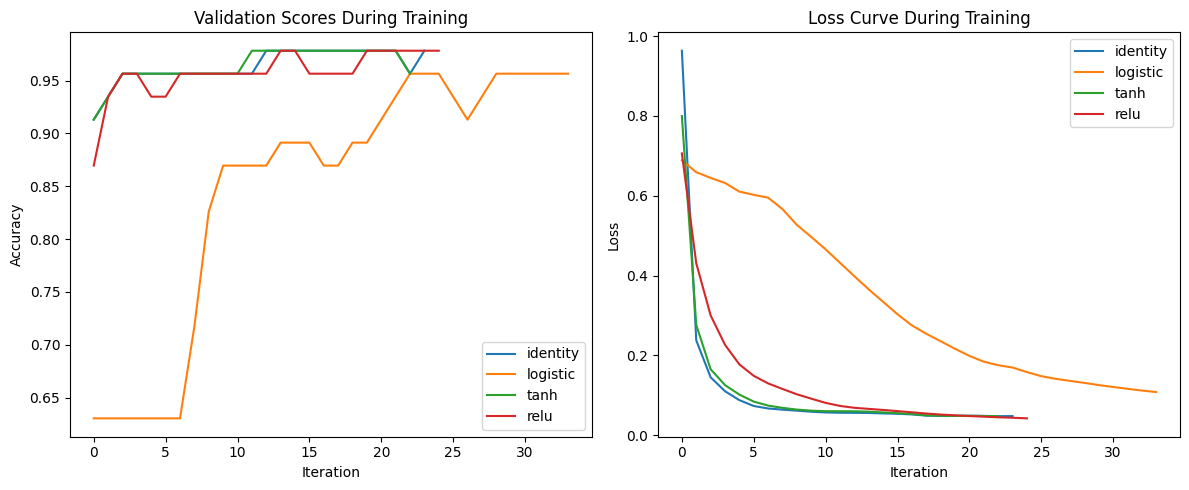

In [41]:
visualize_combined_plots(trained_models)

Here we see, perhaps unexpectedly, that the model using the identity activation function converging fastest to minimal loss. As discussed earlier, this is due to the linear divisibility of the data. This model thus gives us a relatively simple and elegant model to fit the data. Often a simple solution is superior to a more complex one. Tanh and RELU also converge very quickly as expected, the sigmoid needs more iterations.

In [42]:
get_acurracy(trained_models, x_test, y_test)

Out of sample error identity: 0.03508771929824561
Out of sample error logistic: 0.02631578947368421
Out of sample error tanh: 0.03508771929824561
Out of sample error relu: 0.03508771929824561


The analysis of the erros for each model on unseen data highlights an important point and provides a nice final conclusion. It is important to remember that fast and close convergence to the lowest possible loss value is not the goal of MLP. Overfitting must be taken into account. This is beyond the scope of this study but is a foundation in machine learning. We see in the above that the sigmoid function has a higher loss on more iterations but a lower error on unseen data which is desirable in this context.

### 4 Conclusion

In this study, we compared different activation functions in different contexts. The results nicely underline the advantages and disadvantages of these functions and show the importance of the necessary understanding of the properties of these functions. We can conclude that using RELU in hidden layers generally gives the best results. Due to its simplicity, this function is computationally very interesting and transparent. But, of course, we have shown contexts where tanh and identity really shine. In turn, the sigmoid function is very interesting and indispensable in the output layer to represent probabilities but its use cases for using it in the hidden layer are fairly limited. 

## What is the impact of class imbalance and different sampling methods on the performance of machine learning algorithms for classification?

Class imbalance is a common challenge in many real-world classification problems. Having significantly fewer samples for one class can lead to biased models that favor the majority class. This results in poor performance in detecting the minority class. In this research project, we investigate the impact of class imbalance on the performance of two popular machine learning algorithms: Support Vector Machines (SVM) and Neural Networks (NN). We compare the in-sample and out-of-sample performance of these algorithms on datasets with varying degrees of class imbalance using different techniques to address this issue. Our goal is to provide insights into strengths and weaknesses of each algorithm and to identify the effective approach.

### 1 The impact of class imbalance, comparing Support Vector Machines with Neural Networks

In [43]:
# 3 of 8 random state
def create_dataset(weights, n_samples, n_classes,
                   class_sep, n_clusters):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=5)

In [44]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

#### 1.1 Synthetic dataset

Class imbalance refers to a situation where the number of samples in different classes of a dataset is significantly uneven. This can have an impact on the decision boundary learned by a machine learning model, potentially leading to biased or skewed predictions. To illustrate the impact of class imbalances on the decision boundary we generated 4 synthetic datasets. Each set contains 2 classes but the level of imbalance vary.

1. Very unbalanced dataset: \
One class is heavily overrepresented, while the other class is underrepresented. This extreme class imbalance can make it challenging for a model to accurately learn the minority class, as the decision boundary may prioritise the majority class.
2. Unbalanced dataset: \
The majority class is still overrepresented, but the imbalance is not as extreme as the very unbalanced dataset. The decision boundary in this case may show some consideration for the minority class, but it still is influenced by the majority class.
3. Moderate unbalanced dataset \
This dataset still exhibits a noticeable class imbalance, but to a lesser extent compared to the previous dataset.  The decision boundary learned by a model on this dataset may be more balanced, giving reasonable consideration to both classes.
4. Balanced Dataset: \
The last dataset is balanced, with an equal number of samples in each class. There is no class imbalance present, and the decision boundary learned by a model on this dataset should ideally provide fair and accurate predictions for both classes.

#### 1.2 SVM

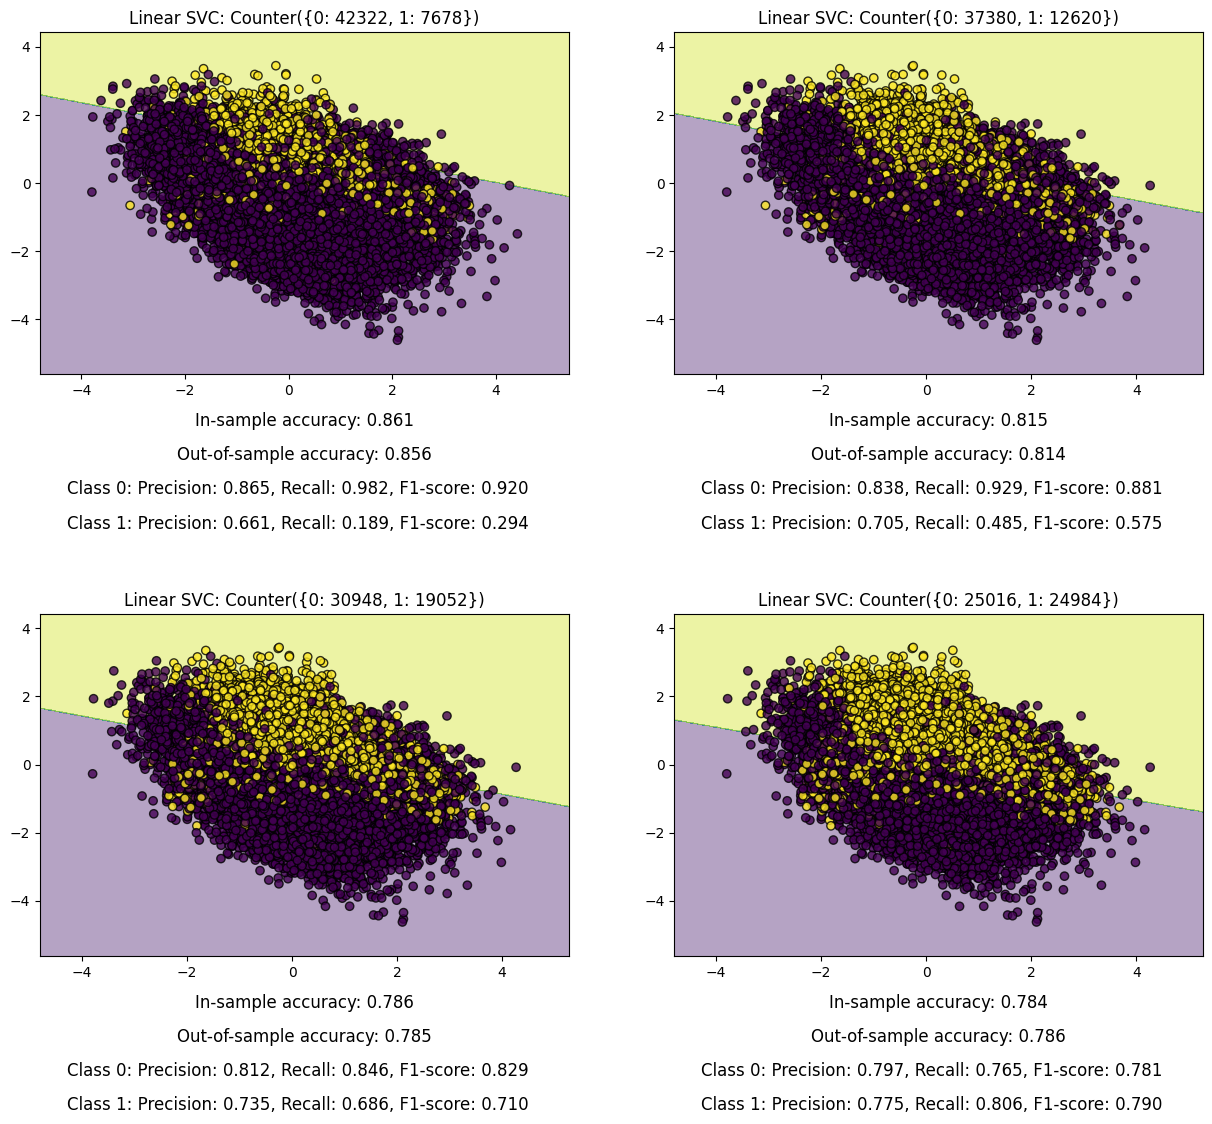

In [45]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.subplots_adjust(wspace=0.2, hspace=0.7)

ax_arr = (ax1, ax2, ax3, ax4)

weights_arr = ((0.85, 0.15), (0.75, 0.25), (0.62, 0.38), (0.5, 0.5))

for ax, weights in zip(ax_arr, weights_arr):
    X, y = create_dataset(weights=weights, n_samples=50000, n_classes=2,
                   class_sep=0.6, n_clusters=2)
 
    ax.set_title('Linear SVC: {}'.format(Counter(y)))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    clf = LinearSVC().fit(X_train, y_train)
    
    plot_decision_function(X, y, clf, ax)
    
    y_true = y_test
    
    
    # compute in-sample error (accuracy on the training set)
    y_pred_train = clf.predict(X_train)
    in_sample_error = accuracy_score(y_train, y_pred_train)

    # compute out-of-sample error (accuracy on the testing set)
    y_pred_test = clf.predict(X_test)
    out_of_sample_error = accuracy_score(y_test, y_pred_test)
    
    cm = confusion_matrix(y_true, y_pred_test)
    
    ax.text(0.5, -0.15, "In-sample accuracy: {:.3f}".format(in_sample_error), transform=ax.transAxes, ha='center', fontsize=12)
    ax.text(0.5, -0.25, "Out-of-sample accuracy: {:.3f}".format(out_of_sample_error), transform=ax.transAxes, ha='center', fontsize=12)
    
    class_labels = np.unique(y)
    report = classification_report(y_true, y_pred_test, zero_division=1, output_dict=True)

    for i, label in enumerate(class_labels):
        ax.text(0.05, -0.35-i*0.1, "Class {}: Precision: {:.3f}, Recall: {:.3f}, F1-score: {:.3f}".format(label, report[str(label)]['precision'], report[str(label)]['recall'], report[str(label)]['f1-score']), transform=ax.transAxes, fontsize=12)




When working with imbalanced datasets, it is important to not only look at the in- and out-of-sample accuracy as a metric to evaluate the performance of the model. Due to the class imbalance, these metrics can be misleading and do not reflect how well the model is handling the minority class.

**Precision** is the ratio of true positives to all the positives. It measures the model's ability to correctly identify positive instances. A high precision indicates a high rate of false positives.

**Recall**, on the other hand, is the ratio of true positives to the sum of true positives and false negatives. It measures the model's ability to correctly identify true positive instances. It is also called the Sensitivity or the True Positive Rate. A high recall indicates a low rate of false negatives.

The **F1-score** is the harmonic mean of precision and recall. It provides a balanced measure of a model's performance on both precision and recall.

These metrics provide a more nuanced understanding of how well the model is performing on imbalanced datasets as they can highlight the model's ability to handle the minority class.

By looking at the in- and out-of-sample error, we can conclude that the model predicting the most unbalanced dataset scored best. The precision and recall of the majority class are high, indicating a low rate of false positives and a high rate of false negatives. Because the class is very unbalanced, this means the model is able to correctly classify the larger majority of the dataset, leading to an in- and out-of-sample accuracy of approximately 0.85.

However, by looking at the F1-score and the recall, we observe that the model is failing to capture the positive instances.

As the dataset gets slightly more balanced, the precision, recall, and F1-score of the minority class improve while keeping the same precision and recall for the majority set. This indicates that balancing the dataset allows the model to have a better opportunity to learn from both classes.

#### 1.3 Neural networks

2023-06-01 21:35:10.415370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 21:35:10.415803: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


469/469 [==============================] - 0s 389us/step


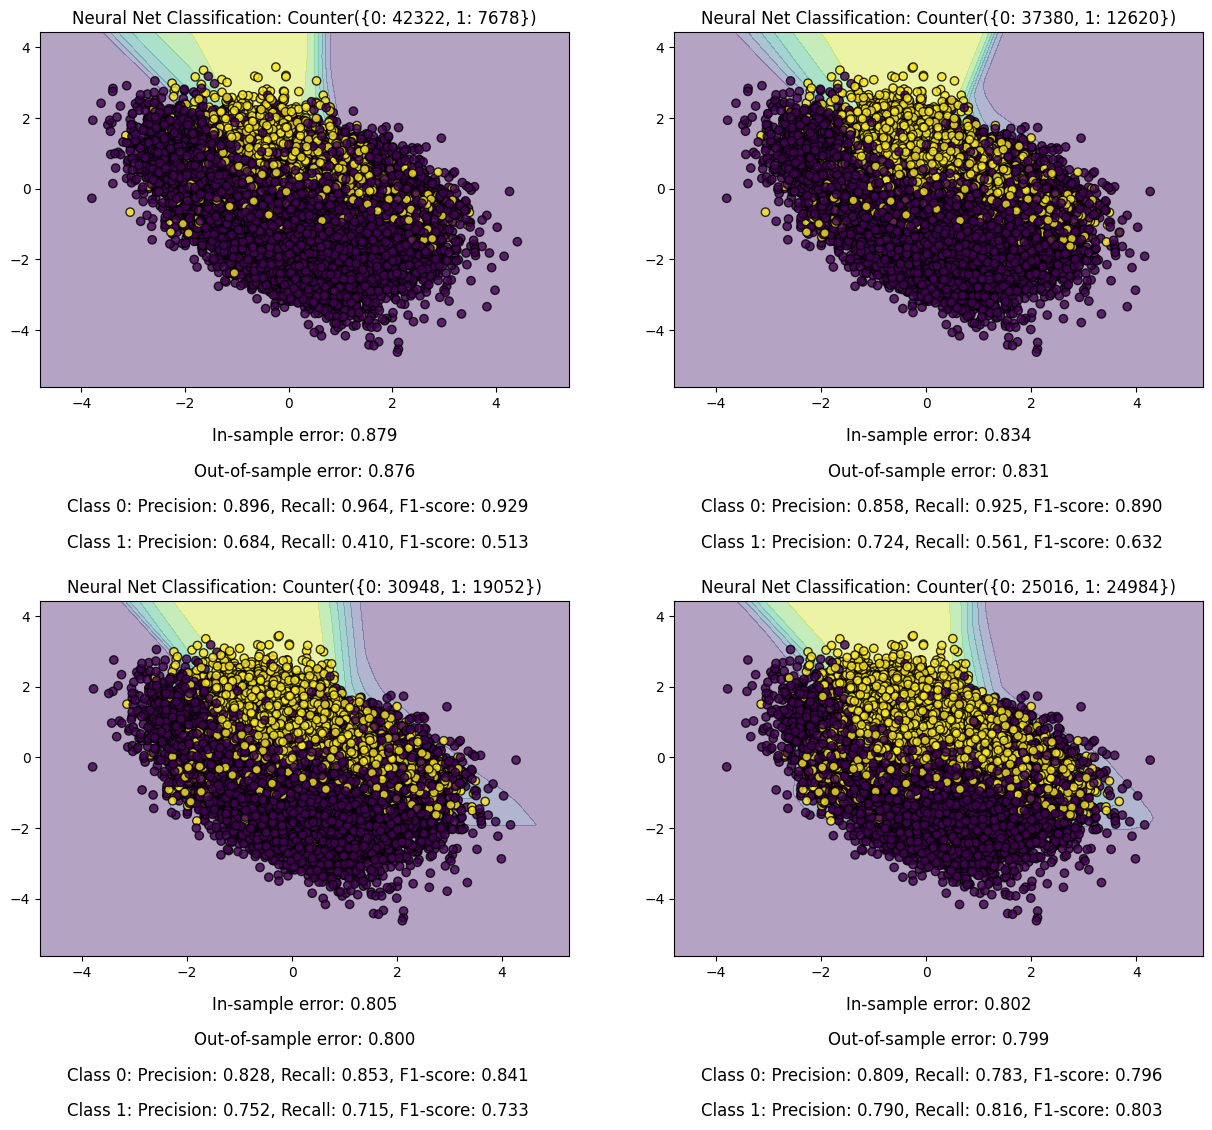

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.subplots_adjust(wspace=0.2, hspace=0.6)

ax_arr = (ax1, ax2, ax3, ax4)

weights_arr = ((0.85, 0.15), (0.75, 0.25), (0.62, 0.38), (0.5, 0.5))

for ax, weights in zip(ax_arr, weights_arr):
    X, y = create_dataset(weights=weights, n_samples=50000, n_classes=2, class_sep=0.6, n_clusters=2)

    ax.set_title('Neural Net Classification: {}'.format(Counter(y)))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Neural Net
    clf = Sequential()
    clf.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
    clf.add(Dense(64, activation='relu')) 
    clf.add(Dense(46, activation='relu'))# Hidden layer
    clf.add(Dense(1, activation='sigmoid'))  # Output layer

    # Compile the model with the custom loss function
    clf.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['acc',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    
    clf.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    plot_decision_function(X, y, clf, ax)
    
    y_true = y_test
    
    # compute in-sample error (accuracy on the training set)
    y_pred_train = clf.predict(X_train)
    in_sample_error = accuracy_score(y_train, np.round(y_pred_train))

    # compute out-of-sample error (accuracy on the testing set)
    y_pred_test = clf.predict(X_test)
    out_of_sample_error = accuracy_score(y_test, np.round(y_pred_test))
    
    ax.text(0.5, -0.15, "In-sample error: {:.3f}".format(in_sample_error), transform=ax.transAxes, ha='center', fontsize=12)
    ax.text(0.5, -0.25, "Out-of-sample error: {:.3f}".format(out_of_sample_error), transform=ax.transAxes, ha='center', fontsize=12)
    
    class_labels = np.unique(y)
    report = classification_report(y_true, np.round(y_pred_test).astype(int), zero_division=1, output_dict=True)

    for label in class_labels:
        ax.text(0.05, -0.35 - label * 0.1, "Class {}: Precision: {:.3f}, Recall: {:.3f}, F1-score: {:.3f}".format(label, report[str(label)]['precision'], report[str(label)]['recall'], report[str(label)]['f1-score']), transform=ax.transAxes, fontsize=12)

    

Based on our observation, we find that a neural network is less influenced by the class imbalance compared to an SVM. This suggests that a neural network may have inherent capabilities to handle the imbalanced dataset more effectively. They can learn complex patterns from data and adapt their internal parameters to handle the class imbalance.

The in- and out-of-sample error of the neural network and SVM predicting the most unbalanced dataset is comparable. However, when considering precision, recall, and F1-score, the neural network demonstrates superior performance.

A recall of approximately 0.5 for the neural network on the most imbalanced dataset indicates that it is able to correctly identify a larger proportion of positive instances in the minority class compared to the SVM's recall of approximately 0.2. Also, the precision and F1-score are higher, indicating that the neural network performs better across all three metrics. Although the metrics are higher, they are not at a satisfactory level. The class imbalance still poses a challenge. We observe that also in the case of the neural network, the metrics improve as the classes get more balanced, indicating the potential of additional techniques to improve performance.

### 2 Oversampling 

#### 2.3 Random over-sampling
The most naive class of techniques for dealing with class imbalances is sampling. Random over-sampling involves duplicating some of the minority class samples at random until the dataset is balanced. This helps the model to learn from more examples of the minority class, potentially improving its ability to classify these instances accurately.

However, this approach of duplicating may not effectively capture the underlying distribution of the minority class, leading to overfitting and biased results.

#### 2.4 SMOTE & ADASYN
Synthetic Minority Over-Sampling (SMOTE) and Adaptive Synthetic Sampling (ADASYN) are more advanced techniques that generate samples based on interpolation. However, the samples used to interpolate new synthetic samples differ. ADASYN is an extension of SMOTE and focuses on generating samples next to the original samples that are wrongly classified using a k-Nearest Neighbors classifier. SMOTE, on the other hand, does not make any distinction between easy and hard samples and generates samples uniformly across the minority class (imbalanced-learn, 2022).


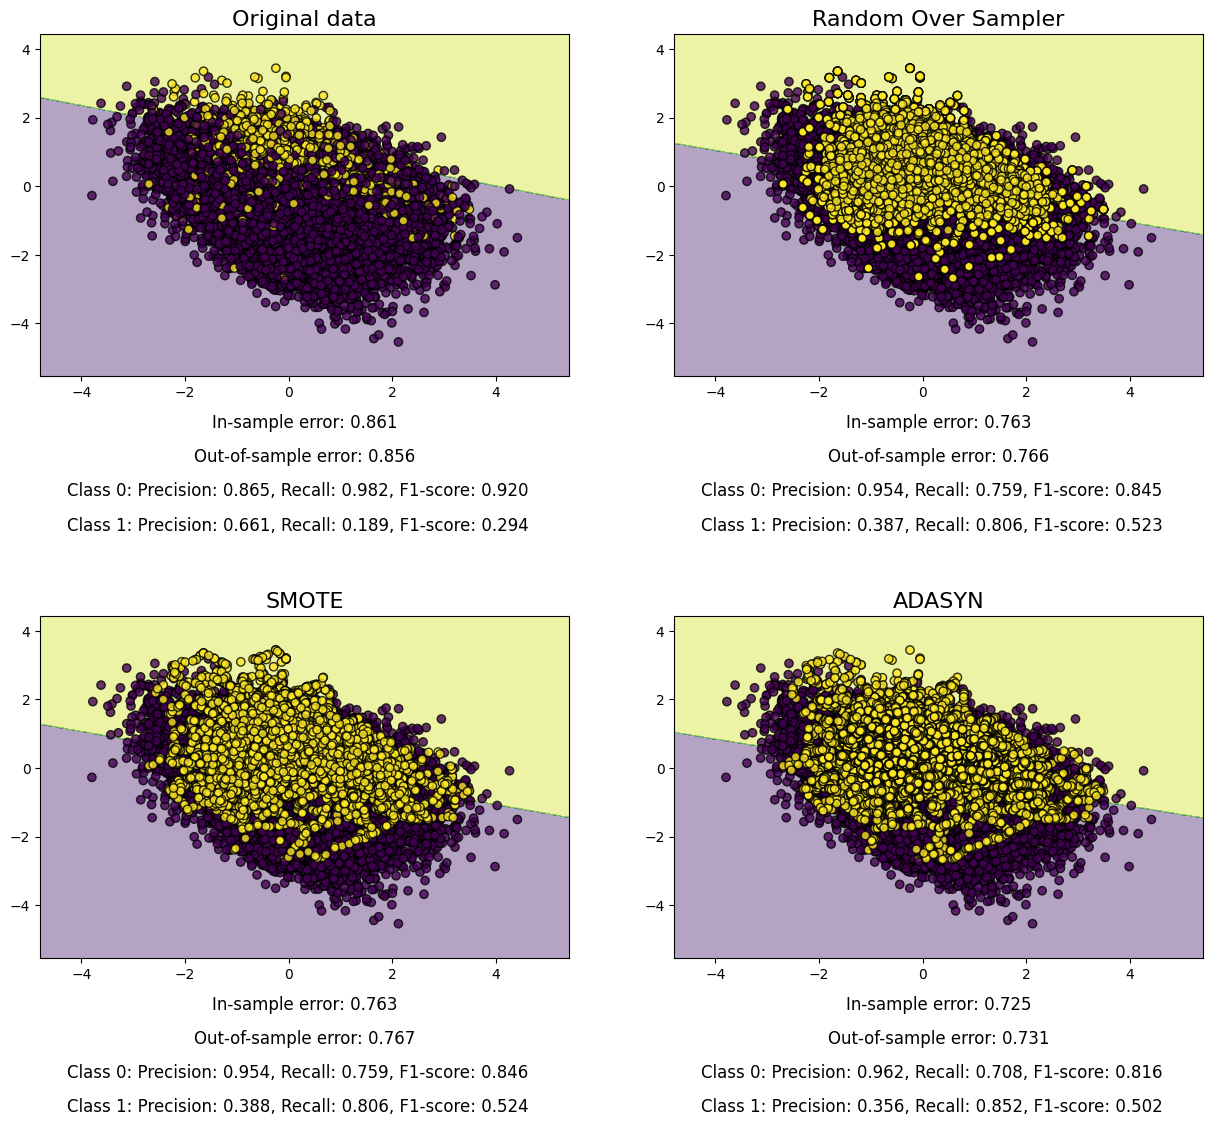

In [47]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.subplots_adjust(wspace=0.2, hspace=0.7)

ax_arr = (ax1, ax2, ax3, ax4)
samplers = [
    FunctionSampler(),
    RandomOverSampler(random_state=0),
    SMOTE(random_state=0),
    ADASYN(random_state=0),
]

titles = ["Original data", "Random Over Sampler", "SMOTE", "ADASYN"]

for ax, sampler, title in zip(ax_arr, samplers, titles):
    X, y = create_dataset(weights=(0.85, 0.15), n_samples=50000, n_classes=2,
                   class_sep=0.6, n_clusters=2)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    clf = LinearSVC()
    
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    clf.fit(X_resampled, y_resampled)
    plot_decision_function(X_resampled, y_resampled, clf, ax)
    
    ax.set_title(title, fontsize=16)
    
    # compute in-sample error (accuracy on the training set)
    y_pred_train = clf.predict(X_train)
    in_sample_error = accuracy_score(y_train, y_pred_train)

    # compute out-of-sample error (accuracy on the testing set)
    y_pred_test = clf.predict(X_test)
    out_of_sample_error = accuracy_score(y_test, y_pred_test)
    
    ax.text(0.5, -0.15, "In-sample error: {:.3f}".format(in_sample_error), transform=ax.transAxes, ha='center', fontsize=12)
    ax.text(0.5, -0.25, "Out-of-sample error: {:.3f}".format(out_of_sample_error), transform=ax.transAxes, ha='center', fontsize=12)
    
    y_true = y_test
    
    class_labels = np.unique(y)
    report = classification_report(y_true, y_pred_test, zero_division=1, output_dict=True)

    for i, label in enumerate(class_labels):
        ax.text(0.05, -0.35-i*0.1, "Class {}: Precision: {:.3f}, Recall: {:.3f}, F1-score: {:.3f}".format(label, report[str(label)]['precision'], report[str(label)]['recall'], report[str(label)]['f1-score']), transform=ax.transAxes, fontsize=12)

To evaluate and compare the effect of different over-sampling techniques, we used the most unbalanced synthetic dataset from the first comparison. We observe an improvement in recall compared to the baseline. This improvement suggests that the models are better at recognizing the minority class and reducing false negative mistakes. However, this improvement comes at the expense of precision. The recall-precision trade-off can be understood as a consequence of sampling positive instances. By increasing the number of positive samples in the training set, the model can become more familiar with the minority class and its unique characteristics. This indirectly lowers the threshold for classifying an instance as positive, leading to more true positive instances from the minority class but also more false positive instances from the majority class. As a result, the precision decreases and recall increases because more true positives lead to fewer false negatives.

469/469 [==============================] - 0s 450us/step


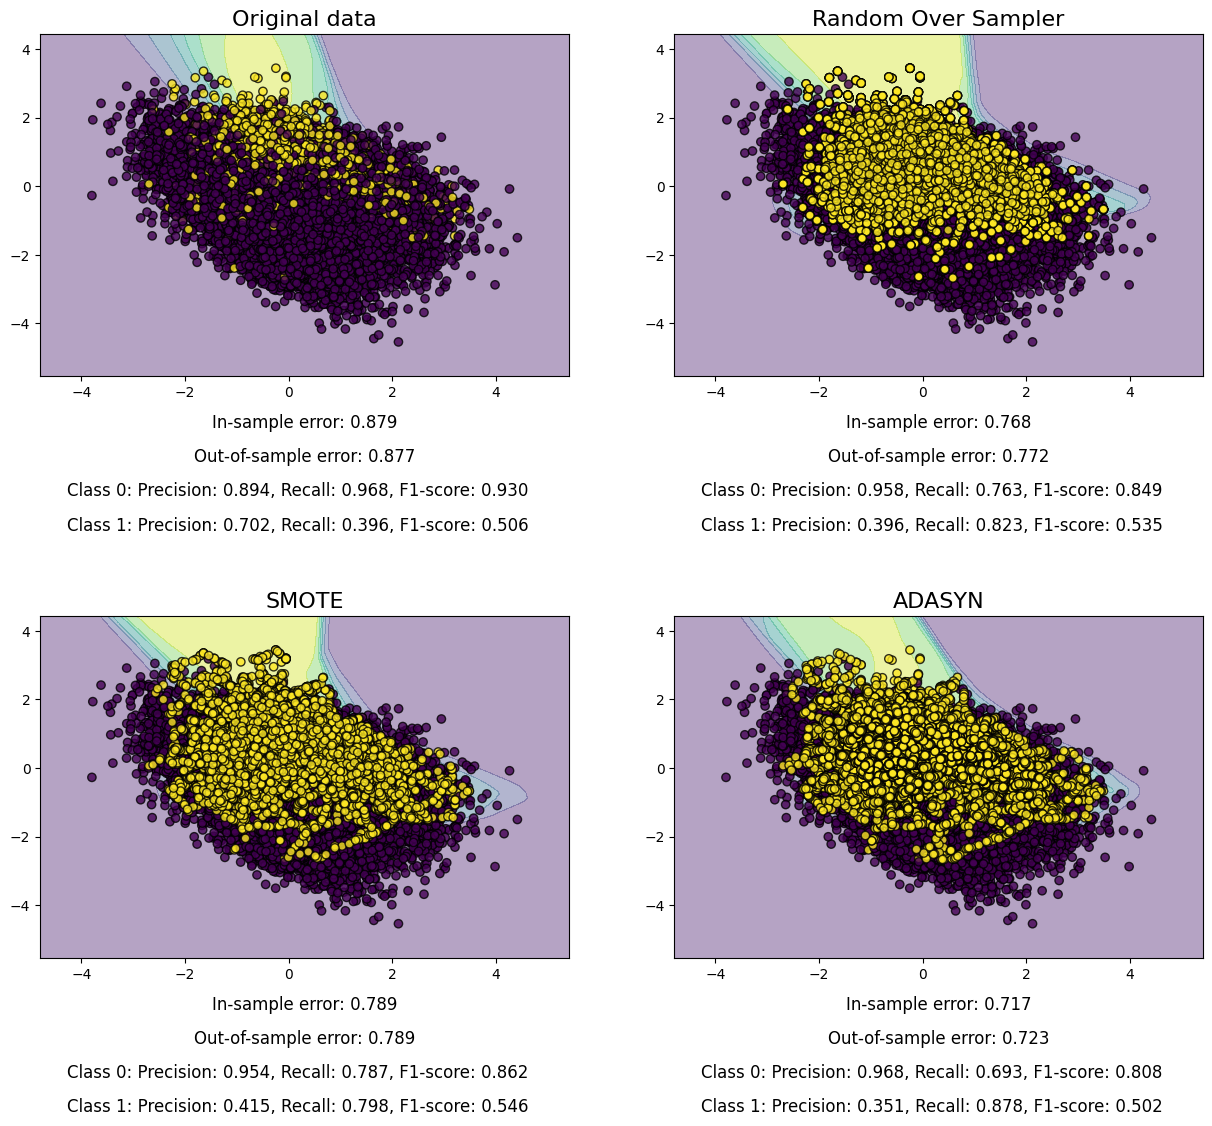

In [50]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.subplots_adjust(wspace=0.2, hspace=0.7)

ax_arr = (ax1, ax2, ax3, ax4)
samplers = [
    FunctionSampler(),
    RandomOverSampler(random_state=0),
    SMOTE(random_state=0),
    ADASYN(random_state=0),
]

titles = ["Original data", "Random Over Sampler", "SMOTE", "ADASYN"]

for ax, sampler, title in zip(ax_arr, samplers, titles):
    X, y = create_dataset(weights=(0.85, 0.15), n_samples=50000, n_classes=2,
                   class_sep=0.6, n_clusters=2)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

    # Neural Net
    #clf = Sequential()
    #clf.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
    #clf.add(Dense(64, activation='relu')) 
    #clf.add(Dense(46, activation='relu'))# Hidden layer
    #clf.add(Dense(1, activation='sigmoid'))  # Output layer
    
    clf = Sequential()
    clf.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    clf.add(Dense(256, activation='relu'))
    clf.add(Dropout(0.5))
    clf.add(Dense(128, activation='relu'))
    clf.add(Dense(64, activation='relu'))
    clf.add(Dropout(0.3))
    clf.add(Dense(1, activation='sigmoid'))


    # Compile the model
    clf.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['acc',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    clf.fit(X_resampled, y_resampled, epochs=50, verbose=0)
    
    plot_decision_function(X_resampled, y_resampled, clf, ax)
    ax.set_title(title, fontsize=16)
    
    y_true = y_test
    
    # compute in-sample error (accuracy on the training set)
    y_pred_train = clf.predict(X_train)
    in_sample_error = accuracy_score(y_train, np.round(y_pred_train))

    # compute out-of-sample error (accuracy on the testing set)
    y_pred_test = clf.predict(X_test)
    out_of_sample_error = accuracy_score(y_test, np.round(y_pred_test))
    
    ax.text(0.5, -0.15, "In-sample error: {:.3f}".format(in_sample_error), transform=ax.transAxes, ha='center', fontsize=12)
    ax.text(0.5, -0.25, "Out-of-sample error: {:.3f}".format(out_of_sample_error), transform=ax.transAxes, ha='center', fontsize=12)
    
    class_labels = np.unique(y)
    report = classification_report(y_true, np.round(y_pred_test).astype(int), zero_division=1, output_dict=True)

    for label in class_labels:
        ax.text(0.05, -0.35 - label * 0.1, "Class {}: Precision: {:.3f}, Recall: {:.3f}, F1-score: {:.3f}".format(label, report[str(label)]['precision'], report[str(label)]['recall'], report[str(label)]['f1-score']), transform=ax.transAxes, fontsize=12)


After applying the over-sampling techniques to the neural network (NN) model, we observed that the F1-score of the minority class remained unchanged. Despite the NN model initially having a higher F1-score compared to the support vector machine (SVM) model, it did not utilise this advantage to further enhance the F1-score. The NN model, similar to the SVM model, is subject to a precision-recall trade-off when dealing with class imbalance. Although the recall experienced significant improvement, it came at the cost of precision.

### 3 Conclusion 

After exploring various techniques, it appears that the trade-off is inevitable. Although there are many more techniques and approaches to explore, our findings suggest that there is no one-size-fits-all solution, and the choice of techniques and trade-offs heavily depends on the specific requirements and objectives of the classification task.

Therefore, it's crucial to carefully evaluate the specific context of the problem at hand. Depending on the problem and the desired balance between precision and recall, different loss functions or sampling techniques may yield different trade-offs and performance outcomes.

### 4 Real-world data
#### 4.1 Diabetes prediction dataset

To further evaluate the effectiveness of the different techniques, we employed the Diabetes prediction kaggle dataset, which is well-suited for our purpose due to its representation of a real-world scenario with a significant class imbalance. It is a collection of medical and demographic data from patience, along with their diabetes status being positive or negative. The data includes features such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level

In [54]:
!kaggle datasets download -p data iammustafatz/diabetes-prediction-dataset

data = pd.read_csv("./data/diabetes-prediction-dataset.zip")
data.head()

diabetes-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

In [57]:
data['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

In [58]:
X = data.drop(['diabetes'], axis=1)
y = data['diabetes']

In [59]:
# Preprocessing - OneHotEncoding Categorical Values
X_encoded = pd.get_dummies(X, columns = ['gender', 'smoking_history'])

# Split beforehand to avoid more randomness comparing the performances
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

In [60]:
samplers = [
    FunctionSampler(),
    RandomOverSampler(random_state=0),
    SMOTE(random_state=0),
    ADASYN(random_state=0),
]

titles = ["Original data", "Random Over Sampler", "SMOTE", "ADASYN"]

for sampler, title in zip(samplers, titles):
    
    clf = LinearSVC(max_iter=10000)
    
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    clf.fit(X_resampled, y_resampled)
    
     
    # compute in-sample error (accuracy on the training set)
    y_pred_train = clf.predict(X_train)
    in_sample_error = accuracy_score(y_train, y_pred_train)

    # compute out-of-sample error (accuracy on the testing set)
    y_pred_test = clf.predict(X_test)
    out_of_sample_error = accuracy_score(y_test, y_pred_test)
    
    print(title)
    print("In-sample error: {:.3f}".format(in_sample_error))
    print("Out-of-sample error: {:.3f}".format(out_of_sample_error))
    
    y_true = y_test
    
    class_labels = np.unique(y)
    report = classification_report(y_true, y_pred_test, zero_division=1, output_dict=True)

    for i, label in enumerate(class_labels):
        print("Class {}: Precision: {:.3f}, Recall: {:.3f}, F1-score: {:.3f}".format(label, 
                                                                                     report[str(label)]['precision'],
                                                                                     report[str(label)]['recall'], 
                                                                                     report[str(label)]['f1-score']))
    print(" ")

Original data
In-sample error: 0.950
Out-of-sample error: 0.948
Class 0: Precision: 0.946, Recall: 1.000, F1-score: 0.972
Class 1: Precision: 0.996, Recall: 0.386, F1-score: 0.557
 
Random Over Sampler
In-sample error: 0.459
Out-of-sample error: 0.459
Class 0: Precision: 1.000, Recall: 0.409, F1-score: 0.580
Class 1: Precision: 0.136, Recall: 1.000, F1-score: 0.239
 
SMOTE
In-sample error: 0.957
Out-of-sample error: 0.954
Class 0: Precision: 0.953, Recall: 0.998, F1-score: 0.975
Class 1: Precision: 0.960, Recall: 0.475, F1-score: 0.636
 
ADASYN
In-sample error: 0.830
Out-of-sample error: 0.829
Class 0: Precision: 0.991, Recall: 0.821, F1-score: 0.898
Class 1: Precision: 0.322, Recall: 0.917, F1-score: 0.477
 


When dealing with heath issues like diabetes it is often more important to have a higher recall indicating fewer false negatives. This is because failing to identify an individual with diabetes results in missing out on necessary treatments or interventions. On the other hand, misdiagnosing a healthy individual and having diabetes and subjecting to unnecessary treatments or interventions can also be unwanted. 

Ultimately, the decision regarding the importance of precision versus recall in diabetes prediction should be made by domain experts who can weigh the potential risks and benefits associated with different outcomes. In this study our focus was primarily on evaluating the impact of class imbalances and the effectiveness of various oversampling techniques on both SVM and NN. 

The LinearSVC model has great in-sample and out-of-sample accuracy, but when working with imbalanced datasets it is important to assess the performance of the model on the minority class. However the precision, recall and F1-score are decent, indicating the SVC model is performing reasonably well in capturing instances of the minority class. Especially the high precision is notable.

Due to the inherent randomness in the sampling techniques and the complexity of the data compared with the synthetic dataset, it can be challenging to directly analyse the results in a deterministic manner. However, it is notable that the F1-score does not show significant improvement after applying the sampling techniques. This suggests that the additional sampling did not effectively enhance the model's performance in capturing the minority class instances. The observed precision-recall trade-off aligns with the expected behaviour. Increasing the recall comes at the expense of precision.

In [61]:
samplers = [
    FunctionSampler(),
    RandomOverSampler(random_state=0),
    SMOTE(random_state=0),
    ADASYN(random_state=0),
]

titles = ["Original data", "Random Over Sampler", "SMOTE", "ADASYN"]

for sampler, title in zip(samplers, titles):

    
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    
    clf = Sequential()
    clf.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    clf.add(Dense(256, activation='relu'))
    clf.add(Dense(128, activation='relu'))
    clf.add(Dense(1, activation='sigmoid'))


    # Compile the model
    clf.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['acc',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    X_resampled = X_resampled.astype('float32')
    y_resampled = y_resampled.astype('float32')

    clf.fit(X_resampled, y_resampled, epochs=50, verbose=0)
    
    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')
    
    # compute in-sample error (accuracy on the training set)
    y_pred_train = clf.predict(X_train)
    in_sample_error = accuracy_score(y_train, np.round(y_pred_train))

    # compute out-of-sample error (accuracy on the testing set)
    y_pred_test = clf.predict(X_test)
    out_of_sample_error = accuracy_score(y_test, np.round(y_pred_test))
    
    print(title)
    print("In-sample error: {:.3f}".format(in_sample_error))
    print("Out-of-sample error: {:.3f}".format(out_of_sample_error))
    
    
    class_labels = np.unique(y_test)
    report = classification_report(y_test, np.round(y_pred_test).astype(int), zero_division=1, output_dict=True)

    for i, label in enumerate(class_labels):
        print("Class {}: Precision: {:.3f}, Recall: {:.3f}, F1-score: {:.3f}".format(label, 
                                                                                     report[str(label)]['precision'],
                                                                                     report[str(label)]['recall'], 
                                                                                     report[str(label)]['f1-score']))
    print(" ")

938/938 [==============================] - 0s 425us/step
Original data
In-sample error: 0.969
Out-of-sample error: 0.968
Class 0.0: Precision: 0.966, Recall: 1.000, F1-score: 0.983
Class 1.0: Precision: 0.996, Recall: 0.625, F1-score: 0.768
 
938/938 [==============================] - 0s 460us/step
Random Over Sampler
In-sample error: 0.890
Out-of-sample error: 0.890
Class 0.0: Precision: 0.993, Recall: 0.886, F1-score: 0.937
Class 1.0: Precision: 0.432, Recall: 0.932, F1-score: 0.590
 
938/938 [==============================] - 0s 438us/step
SMOTE
In-sample error: 0.938
Out-of-sample error: 0.936
Class 0.0: Precision: 0.984, Recall: 0.946, F1-score: 0.965
Class 1.0: Precision: 0.589, Recall: 0.831, F1-score: 0.690
 
938/938 [==============================] - 0s 438us/step
ADASYN
In-sample error: 0.881
Out-of-sample error: 0.880
Class 0.0: Precision: 0.984, Recall: 0.882, F1-score: 0.931
Class 1.0: Precision: 0.401, Recall: 0.848, F1-score: 0.545
 


Also, here the inherent randomness in the sampling techniques and the complexity of the data makes it hard to analyse the performance deterministically. However, in this case, we observe an improvement in the F1-score after applying the SMOTE and ADASYN sampling techniques to the NN model. The increased F1-score suggests that the sampling techniques have been effective in enhancing the NN model's ability to capture instances of the minority class. This sets the NN apart from the SVC. 

## How can the statistical parity fairness notions be satisfied, and how does affect the performance of a machine learning model?
For this research question, we will explore what different approaches are to help satisfy the statistical parity fairness notion. We will look how fairness can be quantified and how it affects the performance of a machine learning model. First, we motivate this research questions by contextualizing the relevance of fairness in machine learning. We briefly introduce fairness and statistical parity. Then, we attempt to satisfy the fairness notion and assess its fairness and performance on a model. Finally, we have a look at the trade-off between performance and fairness.

### 1 Motivation
Machine learning applications are increasingly being applied in the industry. Legislators, insurers and banks are playing catch-up to integrate this technology in the process of decision-making. Supervised learning often relies on historical data. This means that bias present in the data is transferred to the model. Perpetuating this bias is not only unfair, but often unlawful or contrary to company policy. Chouldechova & Roth (2018) identify three possible causes of unfairness:
* **Bias in training data**: historical data that has human bias embedded in it. A classic example is the disproportionate amount of crime committed by some marginalized and ostracized communities. However, this can often be explained by considering the socio-economic situation. Also, these areas might be policed at a higher rate, which further skews crime-prediction models.
* **Minimizing average error**: a majority group will be more accurately represented in a model than a minority group. Naturally, it follows from the fact that the majority group has a larger representation and thus minimizing errors will benefit more if the error of each individual has the same weight. This issue was explored in the previous research question.
* **Related to exploration**: online learning models that get updated with new information while being used, can greatly benefit from the information gained of taking suboptimal decisions. This can be either amoral (e.g. for medical procedures) or benefit/disadvantage certain groups.

Different fairness notions have been introduced in the literature to mitigate problems like these. Knowing which notion to satisfy, depends on the problem and fairness goals.

### 2 Fairness
There are three fairness criteria (Barocas et al., 2017):
* **Independence** $S \bot R$: sensitive features $S$ need to be independent to the scoring metric $R$.
* **Separation** $S \bot R \mid Y$: sensitive features need to be conditionally independent to the scoring metric, given the target variable $Y$.
* **Sufficiency** $S \bot Y \mid R$: sensitive features need to be conditionally independent to the target variable, given the scoring metric.

In general, it is not always possible to satisfy all three criteria. 

A fairness notion is a statistical property that a learned model can satisfy. When it does, the model is fair with respect to that fairness notion. These notions usually address one of the above criteria. Methods that help models satisfy fairness notions can be classified in three groups (Chzhen, 2022):
- **Preprocessing**: methods that transform the training dataset into a more fair representation.
- **Inprocessing**: methods that contribute to fairness during the training procedure.
- **Postprocessing**: methods that increase fairness by means of changing predictions of a model.

We will now introduce statistical parity.

#### 2.1 Statistical parity
There exists different group fairness notions (see Barocas et al., 2017 for an extensive list). Group fairness notions address fairness with respect to a protected group for a sensitive feature. In this work, we only consider **statistical parity** (also known as demographic parity). It is satisfied for a given sensitive feature when the *positive* classification distribution is the same between the protected group and unprotected group (Barocas et al., 2017). This means that predictions need to be statistically independent with respect to the sensitive feature. So, it addresses the independence fairness criteria. For a sensitive attribute $S$ (with $p$ a protected subgroup) and a binary classifier $\hat{Y}$ (with $+$ deemed a *positive* prediction) from dataset $X$, it must hold that for samples $\vec{x} \in X$:
$$\mathbb{P}(\vec{x}(\hat{Y}) = + \mid \vec{x}(S) = p) = \mathbb{P}(\vec{x}(\hat{Y}) = + \mid \vec{x}(S) \ne p)$$

The supervised learning problem is transformed in a multiobjective optimization problem. The two optimization goals become:
* Minimizing the dependency between $S = p$ and $\hat{Y}$.
* Maximizing the accuracy of predictions $Y$.

A way of quantifying the dependency was proposed by Calders et al. (2009). It corresponds to taking the difference in positive prediction rates of both groups on a dataset $X$:
$$\operatorname{dep}_{S=p}(X) := \frac {|\{\vec{x} \in X \mid \vec{x}(S) \ne p, \vec{x}(\hat{Y}) = +\}|} {|\{\vec{x} \in X \mid \vec{x}(S) \ne p\}|} - \frac {|\{\vec{x} \in X \mid \vec{x}(S) = p, \vec{x}(\hat{Y}) = +\}|} {|\{\vec{x} \in X \mid \vec{x}(S) = p\}|}$$

This metric is also called the statistical parity difference.

### 3 Naive fairness through unawareness
In the first problem we will adapt the dependency metric to a regression problem. The approach to improving fairness we employ here will not be effective. However, the way we measure the dependence is still useful in context of regression problems.

#### 3.1 California housing value dataset

The first dataset used for this research question deals with a regression problem. It requires estimation of the median house value for California house districts (Pace & Barry, 1997). In regression problems we can substitute groups and classification by thresholds (Agarwal et al., 2019). An example use case for a model trained on this data could be as guideline for regulating house prices. In turn this could help solve problems such as gentrification by limiting house prices. Below, we fetch the dataset and show the first 10 entries. We will try a naive way of satisfying statistical parity for the final predictive model.

In [62]:
housing_df = fetch_california_housing(as_frame=True).frame
housing_df.head(10)

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
5  4.0368      52.0  4.761658   1.103627       413.0  2.139896     37.85   
6  3.6591      52.0  4.931907   0.951362      1094.0  2.128405     37.84   
7  3.1200      52.0  4.797527   1.061824      1157.0  1.788253     37.84   
8  2.0804      42.0  4.294118   1.117647      1206.0  2.026891     37.84   
9  3.6912      52.0  4.970588   0.990196      1551.0  2.172269     37.84   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  
5    -122.25        2.697  
6    -122.25        2.992  
7    -122.25        2.414  
8    -122.26        2.267  
9    -122.25        2.611

All features are numerical. Analyzing the correlation between the median house value and the other features might give insight into which features impact the house value. In some cases this might be due to bias. We plot the pairwise feature correlations using a heatmap.

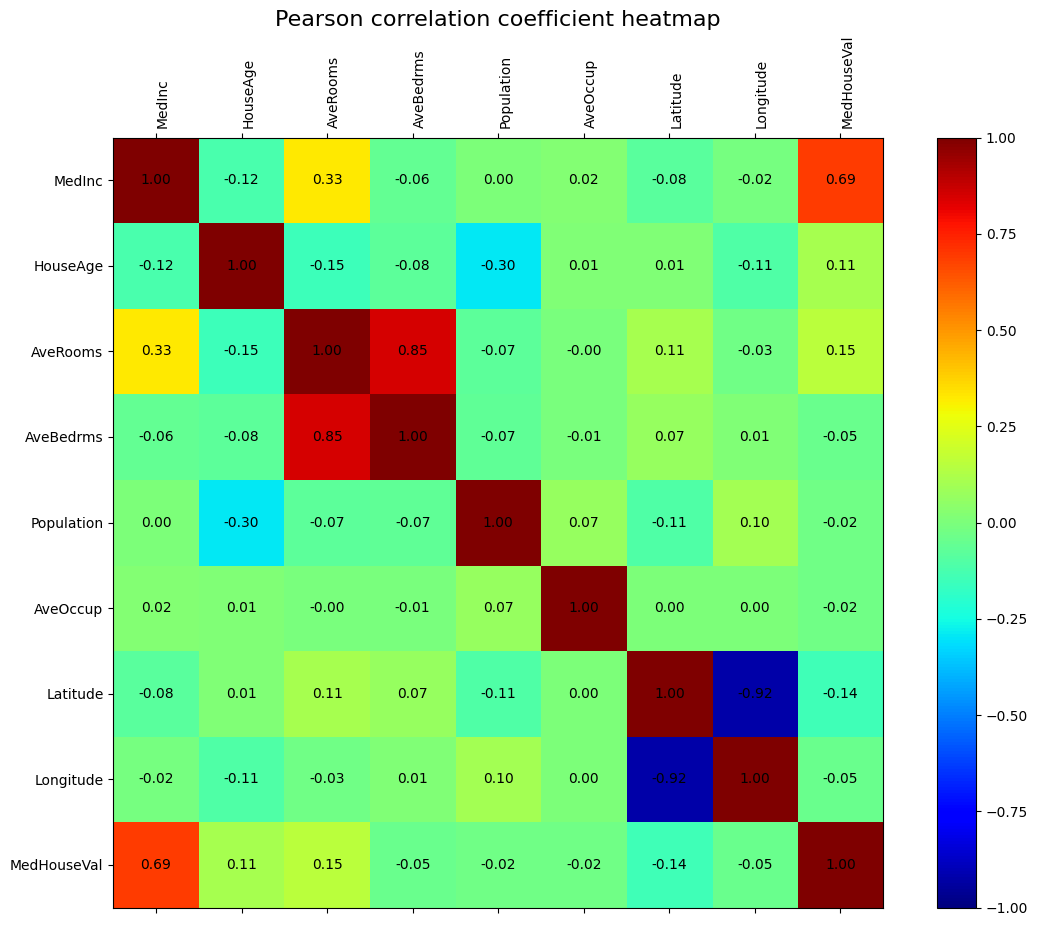

In [63]:
# calculate pearson coefficient matrix
corr = np.corrcoef(housing_df, rowvar=False)

# Show heat map
fig, ax = plt.subplots(figsize=(14,10))
plt.jet()

cax = ax.matshow(corr, vmin=-1, vmax=1)
fig.colorbar(cax)

for (i, j), c in np.ndenumerate(corr):
    ax.text(j, i, f'{c:.2f}', ha='center', va='center')

ax.set_title('Pearson correlation coefficient heatmap', fontsize=16, wrap=True)
ticks = list(range(len(housing_df.columns)))
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(housing_df.columns, rotation=90, horizontalalignment='left')
ax.set_yticklabels(housing_df.columns)
plt.show()

Most features do not seem to correlate with each other. Interestingly, the median income of the district has a high correlation with its median house value. Correlation implies dependence. The heatmap displays the Pearson correlation which check a linear relationship. A more appropriate correlation coefficient is the Spearman correlation because is generalised to a monotonic relationship. To check for significant positive monotonic correlation between median district income and median house value we perform a Spearman correlation statistical test, i.e. $\operatorname{H}_0: \rho \le 0$ (no correlation) and $\operatorname{H}_A: \rho \gt 0$ on significance level $\alpha = 0.05$:

In [64]:
income_spearman_res = spearmanr(housing_df[['MedInc', 'MedHouseVal']], alternative='greater')
print(f'INCOME \ HOUSEVAL: r = {income_spearman_res.statistic:.2f}; p = {income_spearman_res.pvalue}; N = {len(housing_df)}; df = {len(housing_df) - 2}')

INCOME \ HOUSEVAL: r = 0.68; p = 0.0; N = 20640; df = 20638


The test indicates a statistical significant positive monotonic correlation between median income and median house value (of districts in California), $\rho(20640) = 0.68$; $p < 0.001$. This likely is the result of expensive districts attracting upper-class families, while less attractive districts are left to lower-class families. For the sake of this research question, we assume that this is undesired bias (to some extent). We show a scatter plot to visualize the relation:

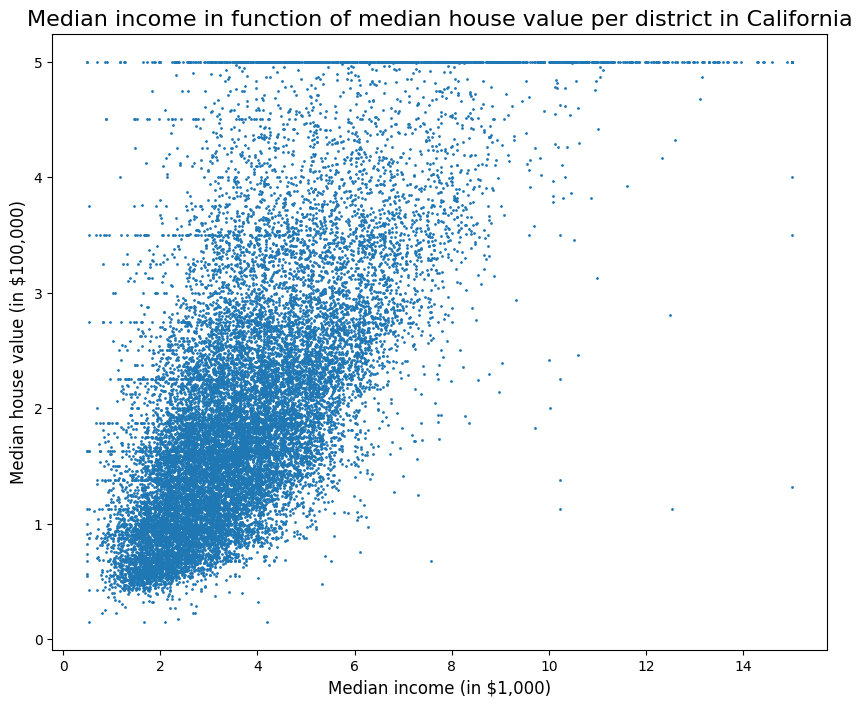

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(housing_df['MedInc'], housing_df['MedHouseVal'], s=1)
ax.set_title('Median income in function of median house value per district in California', fontsize=16, wrap=True)
ax.set_xlabel('Median income (in $1,000)', fontsize=12)
ax.set_ylabel(f'Median house value (in $100,000)', fontsize=12)

plt.show()

We choose median income as sensitive feature. Districts that have a median income that is below the median (of the medians) are designated as protected group, and above median (of the medians) house value is considered a positive *classification*.

Note: Generally protected groups are chosen before looking at the data, usually by following ethical guidelines. Otherwise, we can introduce bias ourselves. Here, we do it to be sure we select a disadvantaged group for the sake of example.

We show a plot to compare protected to unprotected groups and calculate the dependence metric $\operatorname{dep}_{\mathrm{AboveMedInc} = 0}$.

In [66]:
# gets the rate of positive classifications of each sensitive subgroup
def sensitive_rate_df(df_x, df_y, positive):
    df = pd.DataFrame({
        'x': df_x.reset_index(drop=True),
        'y': df_y.reset_index(drop=True)
    })
    return df.groupby('x') \
             .agg(
                 TotalCount=('y', len),
                 Proportion=('y', lambda g: len(g) / len(df)),
                 PositiveCount=('y', lambda g: g.value_counts()[positive]),
                 PositiveRate=('y', lambda g: g.value_counts()[positive] / len(g))
             )

# plots the positive classification reate of each sensitive subgroup
def sensitive_rate_plots(df_xs, df_ys, positives, titles):
    fig, axs = plt.subplots(1, len(titles), figsize=(6.4 * len(titles), 4.8))
    axs = np.atleast_1d(axs)

    for ax, df_x, df_y, positive, title in zip(axs, df_xs, df_ys, positives, titles):
        avg_pos = (df_y == positive).sum() / len(df_y)
        sens_rate = sensitive_rate_df(df_x, df_y, positive)

        bars = ax.bar(sens_rate.index, sens_rate['PositiveRate'])

        ax.bar_label(bars, labels=sens_rate['PositiveCount'])

        ax.set_title(f'{title}, (N = {len(df_x)})', fontsize=16, wrap=True)
        ax.set_xlabel(df_x.name, fontsize=12)
        ax.set_xticks(df_x.unique())
        ax.set_ylabel(f'{df_y.name} rate', fontsize=12)
        ax.axhline(y=avg_pos, linewidth=1, linestyle=':', color='r', label='Overall rate')
        ax.annotate(
            f'{avg_pos:.2f}', 
            xy=(1, avg_pos), 
            xytext=(10, 0),
            xycoords=('axes fraction', 'data'),
            textcoords='offset points',
            va='center',
            color='r'
        )
        ax.legend(loc='lower right')
        
    fig.tight_layout()
    plt.show()

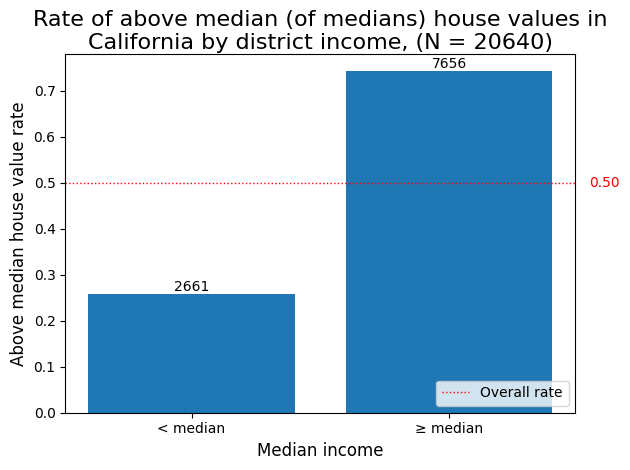

In [67]:
# get protected group
housing_inc_med = housing_df['MedInc'].median()
housing_prot_mask = (housing_df['MedInc'] < housing_inc_med).astype(int)
housing_prot_desc = pd.Series(housing_prot_mask.replace({1: '< median', 0: '≥ median'}), name='Median income')

# get positive classified group
housing_inc_med = housing_df['MedHouseVal'].median()
housing_inc_mask = (housing_df['MedHouseVal'] > housing_inc_med).astype(int)
housing_inc = pd.Series(housing_inc_mask, name='Above median house value')

sensitive_rate_plots(
    [housing_prot_desc],
    [housing_inc],
    [1],
    ['Rate of above median (of medians) house values in California by district income'],
)

In [68]:
# calculates the dependence metric for statistical parity
def fairness_dependence_metric(df_x, df_y, protected_group, positive):
    prot_mask = df_x == protected_group
    pos_mask = df_y == positive

    n_prot = prot_mask.sum()
    n_prot_pos = (prot_mask & pos_mask).sum()

    n_nprot = (~prot_mask).sum()
    n_nprot_pos = (~prot_mask & pos_mask).sum()

    return (n_nprot_pos / n_nprot) - (n_prot_pos / n_prot)

In [69]:
dep_latino = fairness_dependence_metric(
    housing_prot_mask,
    housing_inc_mask,
    1,
    1,
)

print(f'DEP: {dep_latino:.2f}')

DEP: 0.48


Both the plot and the fairness dependence metric show unfairness with respect to statistical parity.

#### 3.2 Preprocessing
The first attempt of increasing fairness involves removing the sensitive feature. It is a preprocessing method that is called **fairness through unawareness**. So in this step, we drop the sensitive feature (median income). We also use a standard scaler to improve performance. Finally, we split the dataset in a train and test set. Eventually we only keep the $k$-best parameters based on the F-statistic, which is recommended.

In [70]:
# input features / target split
housing_y = housing_df['MedHouseVal']
housing_X = housing_df.drop(['MedHouseVal', 'MedInc'], axis=1) # drop target and sensitive feature

housing_scale = StandardScaler()

# training / test split
(
    housing_X_train,
    housing_X_test,
    housing_y_train,
    housing_y_test,
    housing_i_train,
    housing_i_test,
) = train_test_split(
    housing_X, 
    housing_y,
    np.arange(len(housing_df)),
    test_size=0.25,
    random_state=0,
    shuffle=True
)

# select k-best parameters based on F-test
housing_skb = SelectKBest(f_regression)

#### 3.3 Model fitting and hyperparameter search
We proceed with fitting a multi-layer perceptron to the training data. We select the best hyperparameters using randomized grid search with 5-fold cross-validation with MAE to measure performance.

In [71]:
# pipeline with preprocessing and MLP
housing_pipe = Pipeline([
    ('col_standard', housing_scale),
    ('k_best', housing_skb),
    ('mlpr', MLPRegressor(
        max_iter=10000,
        random_state=0))
])

# hyperparameters
housing_params = {
    'k_best__k': randint(5, len(housing_X_train.columns)), # k-best features
    'mlpr__hidden_layer_sizes': [ # hidden layer layout
        (5,), (8,), (10,), (15,),
        (5, 5), (5, 8,), (8, 8), (8, 5), (10, 10), (5, 10), (10, 5)
     ],
    'mlpr__activation': ['identity', 'logistic', 'tanh', 'relu'], # activation function
    'mlpr__alpha': gamma(2, scale=0.001) # learning rate
}

# 5-fold cross-validation
housing_kfcv = KFold(n_splits=5)

# grid search for best parameters
housing_mlpr_rcv = RandomizedSearchCV(
    housing_pipe, 
    housing_params,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    refit=True,
    n_jobs=-1,
    cv=housing_kfcv,
    random_state=0,
    return_train_score=True
)

# fit and print best params
housing_mlpr_rcv.fit(housing_X_train, housing_y_train)
for param, value in housing_mlpr_rcv.best_params_.items():
    print(f'{param}: {value}')

k_best__k: 6
mlpr__activation: tanh
mlpr__alpha: 0.0009505816689836764
mlpr__hidden_layer_sizes: (10, 10)


#### 3.4 Model performance and fairness assessment
Now that the model is fitted, we assess its performance on the test set.

In [72]:
# prints basic performance metrics
def score_summary(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'R^2: {r2:.2f}; MAE: {mae:.2f}; MSE: {mse:.2f}')

In [73]:
housing_y_test_pred = housing_mlpr_rcv.predict(housing_X_test)
score_summary(housing_y_test_pred, housing_y_test)

R^2: 0.66; MAE: 0.40; MSE: 0.34


The mean absolute error of this model within acceptable bounds. We continue by assessing the fairness, as this is another main concern.

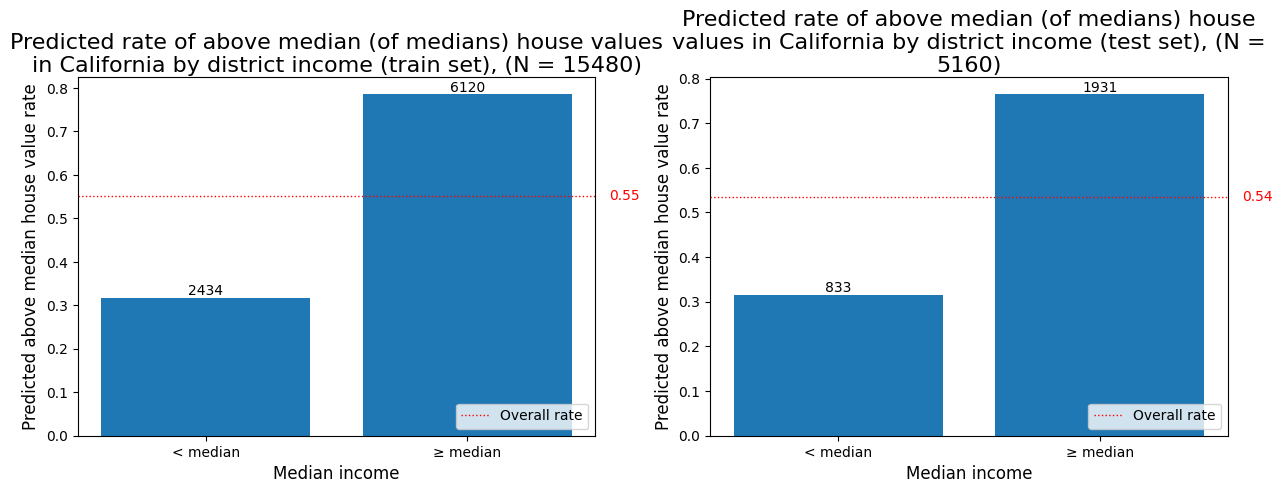

In [74]:
housing_y_train_pred = housing_mlpr_rcv.predict(housing_X_train)

# get protected group
housing_prot_mask_train = housing_prot_mask[housing_i_train]
housing_prot_desc_train = housing_prot_desc[housing_i_train]
housing_prot_mask_test = housing_prot_mask[housing_i_test]
housing_prot_desc_test = housing_prot_desc[housing_i_test]

# get positive classified group
housing_inc_mask_train = (housing_y_train_pred > housing_inc_med).astype(int)
housing_inc_train = pd.Series(housing_inc_mask_train, name='Predicted above median house value')
housing_inc_mask_test = (housing_y_test_pred > housing_inc_med).astype(int)
housing_inc_test = pd.Series(housing_inc_mask_test, name='Predicted above median house value')

sensitive_rate_plots(
    [housing_prot_desc_train, housing_prot_desc_test],
    [housing_inc_train, housing_inc_test],
    [1, 1],
    ['Predicted rate of above median (of medians) house values in California by district income (train set)', 'Predicted rate of above median (of medians) house values in California by district income (test set)'],
)

In [75]:
dep_prot_train = fairness_dependence_metric(
    housing_prot_mask_train,
    housing_inc_mask_train,
    1,
    1,
)

dep_prot_train = fairness_dependence_metric(
    housing_prot_mask_test,
    housing_inc_mask_test,
    1,
    1,
)

print(f'DEP on train: {dep_prot_train:.2f}; DEP on test: {dep_prot_train:.2f}')

DEP on train: 0.45; DEP on test: 0.45


The dependence did not decrease. Fairness through unawareness does generally not lead to a decreased dependence. Moreover, there often exist (a combination of) proxies for the sensitive feature. Here, proxies could include a combination of longitude and latitude. The multi-layer perceptron could learn the non-linear relation that helps identify rich districts.

### 4 Baseline classifier without fairness
We continue to a different problem on classification. The reason is that most literature on fairness is for classification problems. In this section we train a Gaussian naive Bayes Classifier on the dataset without any regard for fairness. The Gaussian naive Bayes model is chosen because of its simplicity and efficiency. But, it is also one of the Scikit-learn models that support sample reweighing which is used in the next section.

#### 4.1 Credit card approval dataset
The dataset for the classification problem is on credit card approval of customers (Dua & Graff 2019). It has already been cleaned, and missing values have been filled (potentially contributing to any bias). The sensitive features include ethnicity and gender. We use this dataset to satisfy statistical parity. We download the dataset, loads it and shows the first 10 entries.

In [97]:
!kaggle datasets download -p data samuelcortinhas/credit-card-approval-clean-data

credit_zip = ZipFile('data/credit-card-approval-clean-data.zip')
credit_df = pd.read_csv(credit_zip.open('clean_dataset.csv'))
credit_df.head(10)

  0%|                                               | 0.00/19.0k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 19.0k/19.0k [00:00<00:00, 249kB/s]


Gender    Age    Debt  Married  BankCustomer               Industry  \
0       1  30.83   0.000        1             1            Industrials   
1       0  58.67   4.460        1             1              Materials   
2       0  24.50   0.500        1             1              Materials   
3       1  27.83   1.540        1             1            Industrials   
4       1  20.17   5.625        1             1            Industrials   
5       1  32.08   4.000        1             1  CommunicationServices   
6       1  33.17   1.040        1             1              Transport   
7       0  22.92  11.585        1             1  InformationTechnology   
8       1  54.42   0.500        0             0             Financials   
9       1  42.50   4.915        0             0            Industrials   

  Ethnicity  YearsEmployed  PriorDefault  Employed  CreditScore  \
0     White          1.250             1         1            1   
1     Black          3.040             1         1            6   
2     Black          1.500             1         0            0   
3     White          3.750             1         1            5   
4     White          1.710             1         0            0   
5     White          2.500             1         0            0   
6     Black          6.500             1         0            0   
7     White          0.040             1         0            0   
8     Black          3.960             1         0            0   
9     White          3.165             1         0            0   

   DriversLicense       Citizen  ZipCode  Income  Approved  
0               0       ByBirth      202       0         1  
1               0       ByBirth       43     560         1  
2               0       ByBirth      280     824         1  
3               1       ByBirth      100       3         1  
4               0  ByOtherMeans      120       0         1  
5               1       ByBirth      360       0         1  
6               1       ByBirth      164   31285         1  
7               0       ByBirth       80    1349         1  
8               0       ByBirth      180     314         1  
9               1       ByBirth       52    1442         1

The approval rates for the different genders and ethnicities are interesting properties, as these are considered sensitive features in society. The rate of each sensitive feature with the overall rate is visualised using a bar charts below. Each subgroup has the count of the approved group members on top of the bar.

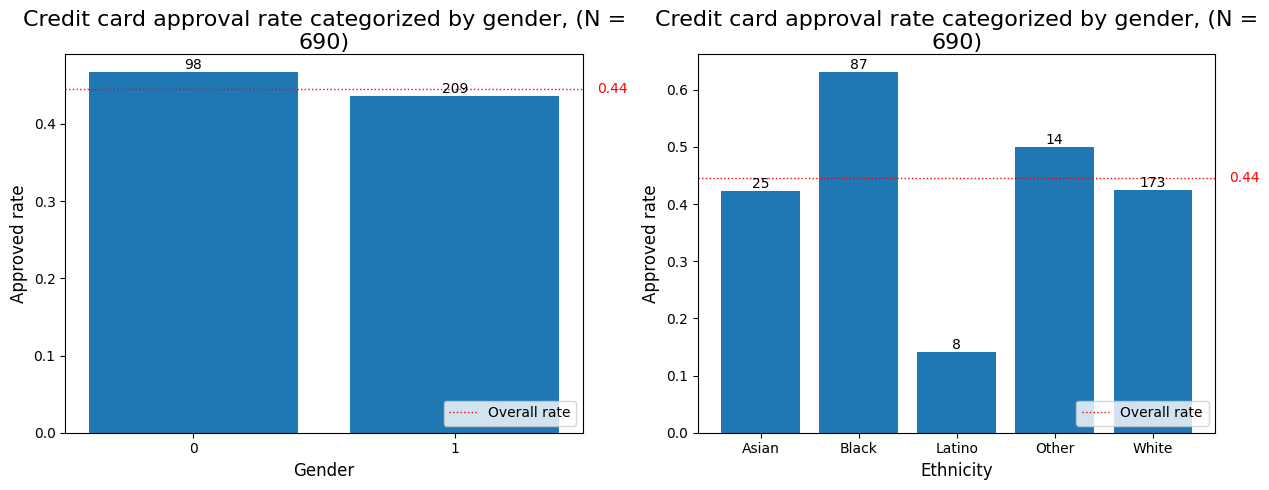

In [77]:
sensitive_rate_plots(
    [credit_df['Gender'], credit_df['Ethnicity']],
    [credit_df['Approved'], credit_df['Approved']],
    [1, 1],
    ['Credit card approval rate categorized by gender', 'Credit card approval rate categorized by gender'],
)

We clearly see that approval rates are not consistent across groups, especially for ethnicity. We perform a $\chi^2$-test to test for dependence ($H_A$) with significance level $\alpha = 0.05$, both between gender and approval, and ethnicity and approval.

In [78]:
gender_contingency = pd.crosstab(index=credit_df['Gender'], columns=credit_df['Approved'])
gender_chi2_res = chi2_contingency(gender_contingency)
print(f'GENDER: X^2 = {gender_chi2_res.statistic:.2f}; p = {gender_chi2_res.pvalue:.2}; N = {len(credit_df)}; df = {gender_chi2_res.dof}')

ethnicity_contingency = pd.crosstab(index=credit_df['Ethnicity'], columns=credit_df['Approved'])
ethnicity_chi2_res = chi2_contingency(ethnicity_contingency)
print(f'ETHNICITY: X^2 = {ethnicity_chi2_res.statistic:.2f}; p = {ethnicity_chi2_res.pvalue:.2}; N = {len(credit_df)}; df = {ethnicity_chi2_res.dof}')

GENDER: X^2 = 0.46; p = 0.5; N = 690; df = 1
ETHNICITY: X^2 = 41.81; p = 1.8e-08; N = 690; df = 4


The first test indicates that there is no indication of dependence between gender and approval ($H_0$ not rejected), $\chi^2(1, 690) = 0.5$; $p = 0.5$.
There is a statistical significant relationship between ethnicity of a customer and their credit card approval, $\chi^2(4, 690) = 41.8$; $p < 0.001$. This could be an indication of bias in the training set. Regardless of bias, statistical parity aims to remove the dependency of a sensitive feature.
We choose ethnicity as sensitive feature for satisfying statistical parity, and Latinos as protected group.

Note: Because the test failed to indicate there is dependence between gender and approval, it does not prove independence. Moreover, statistical parity should be satisfied on the predictive model, but we only looked at dependence in the dataset. Therefore, satisfying statistical parity for gender could also be a requirement. Here, we choose to only satisfy this fairness notion with respect to ethnicity for simplicity.

Calculating the dependence metric $\operatorname{dep}_{E = \mathrm{Latino}}$:

In [79]:
dep_latino = fairness_dependence_metric(
    credit_df['Ethnicity'],
    credit_df['Approved'],
    'Latino',
    1
)

print(f'DEP: {dep_latino:.2f}')

DEP: 0.33


#### 4.2 Preprocessing
We start by performing preprocessing on the dataset. The Gaussian naive Bayes works best on normal distributed data. Therefore, we perform a transformation to standardise the features. Nominal categories are one-hot encoded to dummy columns for each possible category. Eventually we only keep the $k$-best features based on the F-statistic, which is recommended. The data is transformed using the above defined preprocessing. It is then split the dataset into training and test set. We use a stratification scheme that ensures a proportional representation of the target feature (approval) in the resulting test and training set.

In [80]:
# appropriate preprocessing on each feature
credit_nom = (
    'encode_nominals',
    OneHotEncoder(), # create dummy features
    ['Ethnicity', 'Industry', 'Citizen']
)
credit_std = (
    'standard_scale',
    StandardScaler(), # standardize data
    ['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'Income']
)
credit_pass = (
    'pass',
    'passthrough', # keep other useful features
    ['Gender', 'Married', 'BankCustomer', 'PriorDefault', 'Employed', 'DriversLicense']
)

credit_ctf = ColumnTransformer(
    transformers=[credit_nom, credit_std, credit_pass],
    remainder='drop' # remove other features
)

# select K best parameters based on F-test
credit_skb = SelectKBest(f_regression)

# input features / target split
credit_y = credit_df['Approved']
credit_X =  credit_df.drop('Approved', axis=1)

# training / test split
(
    credit_X_train,
    credit_X_test,
    credit_y_train,
    credit_y_test
) = train_test_split(
    credit_X, 
    credit_y, 
    test_size=0.25,
    random_state=0,
    shuffle=True,
    stratify=credit_y
)

#### 4.3 Model fitting and hyperparameter search
Here, the Gaussian naive Bayes classifier is fit to the training data. To select the best amount of features, we perform a grid search. The grid search uses a 5-fold cross-validation to get the best hyperparameter.

In [81]:
# pipeline with preprocessing and Gaussian Naive classifier model
credit_pipe = Pipeline([
    ('col_trans', credit_ctf),
    ('k_best', credit_skb),
    ('gnb', GaussianNB())
])

# hyperparameters
credit_params = {
    'k_best__k': np.linspace(10, 25, 10, dtype=int)
}

# 5-fold cross-validation
credit_kfcv = KFold(n_splits=5, shuffle=True, random_state=0)

# grid search for best parameters
credit_gnb_gs = GridSearchCV(
    credit_pipe, 
    credit_params,
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    cv=credit_kfcv,
    return_train_score=True
)

# fit and print best params
credit_gnb_gs.fit(credit_X_train, credit_y_train)
for param, value in credit_gnb_gs.best_params_.items():
    print(f'{param}: {value}')

k_best__k: 10


#### 4.4 Model performance and fairness assessment
Now that the model is fitted, we assess its performance on the test set.

In [82]:
credit_y_test_pred = credit_gnb_gs.predict(credit_X_test)
score_summary(credit_y_test_pred, credit_y_test)

R^2: 0.47; MAE: 0.13; MSE: 0.13


The fitted model has an accuracy of prediction is $1-\operatorname{MAE} = 0.87$, which is decent. We look at the predicted rates by ethnicity, both for the training set and test set. Also, we quantify the dependence using the dependence metric $\operatorname{dep}_{E = \mathrm{Latino}}$.

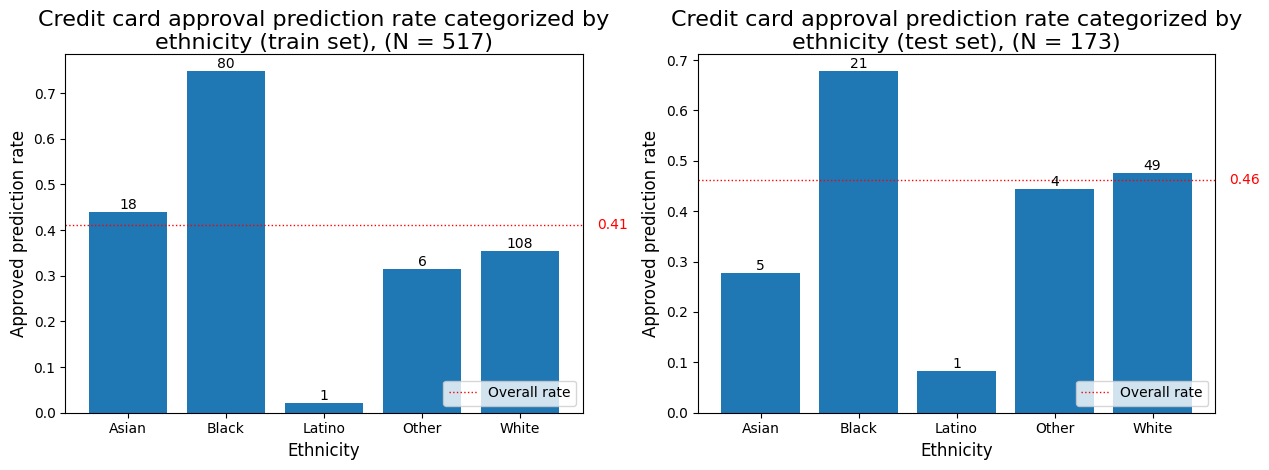

In [83]:
credit_y_train_pred = credit_gnb_gs.predict(credit_X_train)

sensitive_rate_plots(
    [credit_X_train['Ethnicity'], credit_X_test['Ethnicity']],
    [pd.Series(credit_y_train_pred, name='Approved prediction'), pd.Series(credit_y_test_pred, name='Approved prediction')],
    [1, 1],
    ['Credit card approval prediction rate categorized by ethnicity (train set)', 'Credit card approval prediction rate categorized by ethnicity (test set)']
)

In [84]:
dep_latino_train = fairness_dependence_metric(
    credit_X_train['Ethnicity'],
    credit_y_train_pred,
    'Latino',
    1
)

dep_latino_test = fairness_dependence_metric(
    credit_X_test['Ethnicity'],
    credit_y_test_pred,
    'Latino',
    1
)

print(f'DEP on train: {dep_latino_train:.2f}; DEP on test: {dep_latino_test:.2f}')

DEP on train: 0.43; DEP on test: 0.41


The plots indicate the model is not fair with respect to statistical parity. The dependence metric reflects this bad fairness. It is as worse than the initial dataset.

### 5 Fairness through reweighing
In this section we attempt to make the previous predictive model satisfy statistical parity. Calders et al. (2009) proposed two methods of doing so. **Massaging** reduces the dependency by changing the target feature in the dataset. Admittedly, this is intrusive. The **reweighing** approach associates weights to samples corresponding to their target classes and sensitive feature. Reweighing is considered a preprocessing fairness method, but the weights are used during training. We will use the reweighing approach, as Gaussian naive Bayes supports weighted samples and because it leaves the original predictions unchanged.

#### 5.1 Preprocessing
We first start by constructing a modification to the preprocessing transformer. It no longer allows for ethnicity to be used in the model.

In [85]:
# keep same feature transformer, only drop ethnicity
credit_nominal_rw = ['Industry', 'Citizen']
credit_nom_rw = (
    'encode_nominals',
    OneHotEncoder( # create dummy features
        categories=[  # set explicit categories, necessary for ROC later on
            credit_df[feat].unique()
            for feat in credit_nominal_rw
        ],
        sparse_output=False # necessary for ROC later on
    ),
    credit_nominal_rw,
)
credit_ctf_rw = ColumnTransformer(
    transformers=[credit_nom_rw, credit_std, credit_pass],
    remainder='drop'
)

Next, the weights for each sample are calculated. The following formula was derived from Calders et al. (2009), each sample $\vec{x} \in X$ with sensitive feature $S = s$ and target value $Y = y$ has weight:
$$W_{s, y} = \frac {|\{\vec{z} \in X \mid \vec{z}(S) = s\}| |\{\vec{z} \in X \mid \vec{z}(Y) = y\}|} {|\{\vec{z} \in X \mid \vec{z}(S) = s, \vec{z}(Y) = y\}||X|}$$

In [86]:
def dependence_weights(df_x, df_y, protected_group, positive):
    prot_mask = df_x == protected_group
    pos_mask = df_y == positive

    n = len(df_y)
    
    n_prot = prot_mask.sum()
    n_pos = pos_mask.sum()
    n_nprot = n - prot_mask.sum()
    n_npos = n - pos_mask.sum()

    n_prot_pos = (prot_mask & pos_mask).sum()
    n_prot_npos = (prot_mask & ~pos_mask).sum()
    n_nprot_pos = (~prot_mask & pos_mask).sum()
    n_nprot_npos = (~prot_mask & ~pos_mask).sum()

    weights = np.ones(n)

    weights[prot_mask & pos_mask] = (n_prot * n_pos) / (n_prot_pos * n)
    weights[prot_mask & ~pos_mask] = (n_prot * n_npos) / (n_prot_npos * n)
    weights[~prot_mask & pos_mask] = (n_nprot * n_pos) / (n_nprot_pos * n)
    weights[~prot_mask & ~pos_mask] = (n_nprot * n_npos) / (n_nprot_npos * n)
    
    return weights

In [87]:
credit_weights = dependence_weights(
    credit_X_train['Ethnicity'],
    credit_y_train,
    'Latino',
    1
)

np.unique(credit_weights)

array([0.62451644, 0.93324737, 1.06080705, 4.00386847])

#### 5.2 Model fitting and hyperparameter search
The Gaussian Naive Bayes is fitted with the training data and weights. This is the same as before, but we make sure to use preprocessing that excludes the ethnicity attribute and include the sample weights.

In [88]:
# pipeline with preprocessing and Gaussian naive Bayes
credit_pipe_rw = Pipeline([
    ('col_trans', credit_ctf_rw), # transformer without ethnicity
    ('k_best', credit_skb),
    ('gnb', GaussianNB())
])

# grid search for best parameters
credit_gnb_gs_rw = GridSearchCV(
    credit_pipe_rw, 
    credit_params,
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    cv=credit_kfcv,
    return_train_score=True
)

# fit using sample weights and print best params
credit_gnb_gs_rw.fit(
    credit_X_train, 
    credit_y_train,
    gnb__sample_weight=credit_weights
)
for param, value in credit_gnb_gs_rw.best_params_.items():
    print(f'{param}: {value}')

k_best__k: 18


#### 5.3 Model performance and fairness assessment

In [89]:
credit_y_test_pred_rw = credit_gnb_gs_rw.predict(credit_X_test)
score_summary(credit_y_test_pred_rw, credit_y_test)

R^2: 0.26; MAE: 0.18; MSE: 0.18


The fitted model has an accuracy of prediction is $1-\operatorname{MAE} = 0.82$. This means the accuracy only went down by $5%$. The loss in performance on the test set is not inherently bad. A fair model that always predicts correctly and fairly will not perform as good on a biased dataset as an unfair model (which potentially overfits) on the dataset. With fairness in mind, one has to look at both performance and fairness. So, next we look at the predicted rates by ethnicity again and calculate the dependence using the $\operatorname{dep}_{E = \mathrm{Latino}}$ metric.

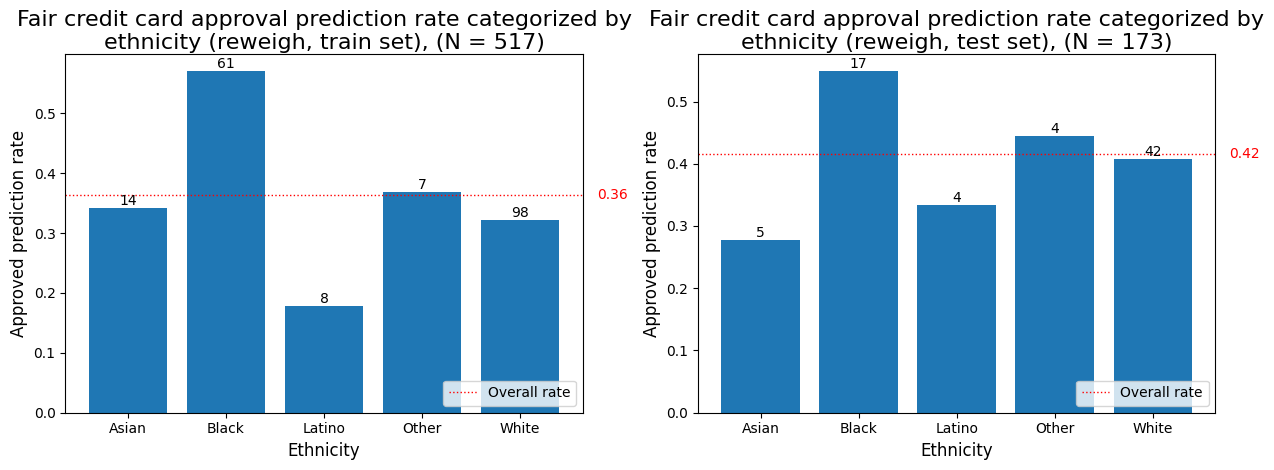

In [90]:
credit_y_train_pred_rw = credit_gnb_gs_rw.predict(credit_X_train)

sensitive_rate_plots(
    [credit_X_train['Ethnicity'], credit_X_test['Ethnicity']],
    [pd.Series(credit_y_train_pred_rw, name='Approved prediction'), pd.Series(credit_y_test_pred_rw, name='Approved prediction')],
    [1, 1],
    ['Fair credit card approval prediction rate categorized by ethnicity (reweigh, train set)', 'Fair credit card approval prediction rate categorized by ethnicity (reweigh, test set)']
)

In [91]:
dep_latino_train_rw = fairness_dependence_metric(
    credit_X_train['Ethnicity'],
    credit_y_train_pred_rw,
    'Latino',
    1
)

dep_latino_test_rw = fairness_dependence_metric(
    credit_X_test['Ethnicity'],
    credit_y_test_pred_rw,
    'Latino',
    1
)

print(f'DEP on train: {dep_latino_train_rw:.2f}; DEP on test: {dep_latino_test_rw:.2f}')

DEP on train: 0.20; DEP on test: 0.09


The plots indicate much better fairness for the protected group. The dependence metric confirms this result: it is a fourth of the initial (unfair) model.

### 6 Fairness through Reject Option based Classification
The final improvement to the classifier involves post-processing using **Reject Option based Classification** (ROC). Essentially, it is a method that favors the outcome of the protected group, while giving unfavorable outcomes to the other. It does this for samples close to decision boundaries (so-called *critical region*). Formally, it looks at the posterior probability of a sample. The uncertainty of its probability of classification will decide if the sample should get another classification based on a threshold with a margin (Kamiran & et al., 2012).

#### 6.1 Model fit and hyperparameter search
We keep the preprocessing from the previous model. We use the Scikit-learn compatible module `aif360` that implements ROC. It performs a grid search for the best threshold and margin with respect to the dependence metric.

In [92]:
# RejectOptionClassifier expects index by sensitive feature, with default 0 for the protected group
credit_i_train_roc = pd.Index(credit_X_train['Ethnicity'] != 'Latino', dtype=int, name='LatinoEthnicity')
credit_X_train.index = credit_i_train_roc
credit_y_train.index = credit_i_train_roc

# get k-best from previous result
credit_skb_roc = SelectKBest(k=credit_gnb_gs_rw.best_params_['k_best__k'])

# pipeline with preprocessing, Gaussian naive Bayes and ROC postprocessing
# uses wrapper that splits traing set into sets for estimator and postprocessor to prevent information leakage
credit_ppm_roc = PostProcessingMeta(
    Pipeline([
        ('col_trans', credit_ctf_rw),
        ('k_best', credit_skb),
        ('gnb', GaussianNB())
    ]).set_output(transform='pandas'),
    RejectOptionClassifierCV( # GridSearchCV equivalent for ROC, finds best margin and threshold
        'LatinoEthnicity',
        scoring='statistical_parity', # statistical parity scoring metric similar to dependence metric
        step=0.05,
        cv=credit_kfcv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    ),
    random_state=0
)

# fit using sample weights and print best params
credit_ppm_roc.fit(
    credit_X_train, 
    credit_y_train,
    # gnb__sample_weight=credit_weights
)
for param, value in credit_ppm_roc.postprocessor_.best_params_.items():
    print(f'postprocessor__{param}: {value}')

postprocessor__margin: 0.44999999999999996
postprocessor__prot_attr: LatinoEthnicity
postprocessor__threshold: 0.55


#### 6.2 Model performance and fairness assessment

In [93]:
credit_i_test_roc = pd.Index(credit_X_test['Ethnicity'] != 'Latino', dtype=int, name='LatinoEthnicity')
credit_X_test.index = credit_i_test_roc

credit_y_test_pred_roc = credit_ppm_roc.predict(credit_X_test)
score_summary(credit_y_test_pred_roc, credit_y_test)

R^2: -6.97; MAE: 0.39; MSE: 0.39


The model performance has drastically decreased to an accuracy. The negative $R^2$ value indicates the model performs worse than the mean target values. We plot the predicted rates and calculate the dependence one last time.

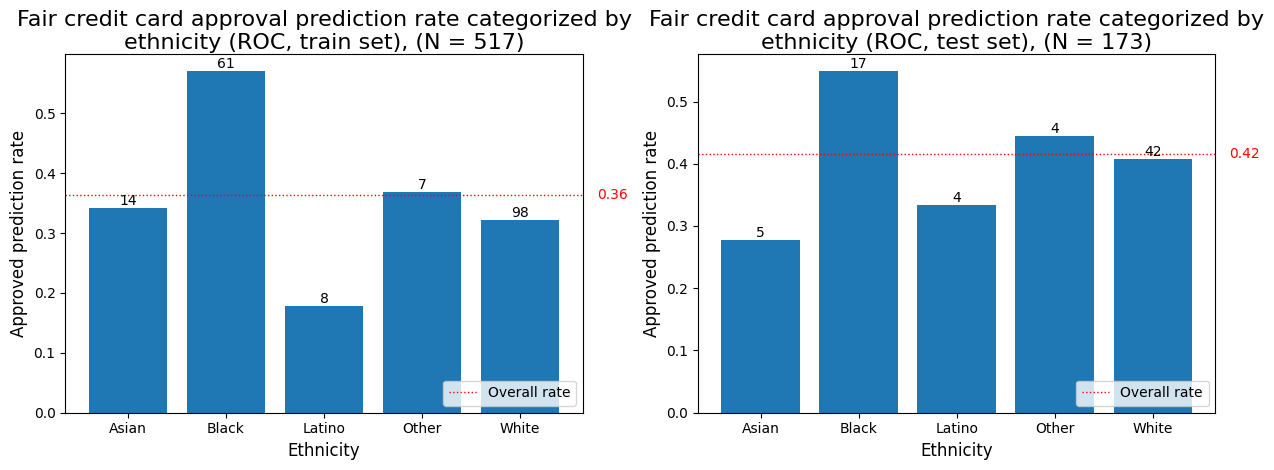

In [94]:
credit_y_train_pred_roc = credit_ppm_roc.predict(credit_X_train)

sensitive_rate_plots(
    [credit_X_train['Ethnicity'], credit_X_test['Ethnicity']],
    [pd.Series(credit_y_train_pred_rw, name='Approved prediction'), pd.Series(credit_y_test_pred_rw, name='Approved prediction')],
    [1, 1],
    ['Fair credit card approval prediction rate categorized by ethnicity (ROC, train set)', 'Fair credit card approval prediction rate categorized by ethnicity (ROC, test set)']
)

In [95]:
dep_latino_train_roc = fairness_dependence_metric(
    credit_X_train['Ethnicity'],
    credit_y_train_pred_roc,
    'Latino',
    1
)

dep_latino_test_roc = fairness_dependence_metric(
    credit_X_test['Ethnicity'],
    credit_y_test_pred_roc,
    'Latino',
    1
)

print(f'DEP on train: {dep_latino_train_roc:.2f}; DEP on test: {dep_latino_test_roc:.2f}')

DEP on train: -0.01; DEP on test: -0.12


The dependence is nearly completely gone. It has even shifted in favor of the protected group. But, at a significant performance penalty. This is due to the relatively high threshold and margin obtained from the grid search. To conclude, we visualize the performance and fairness trade-off governed by the threshold and margin.

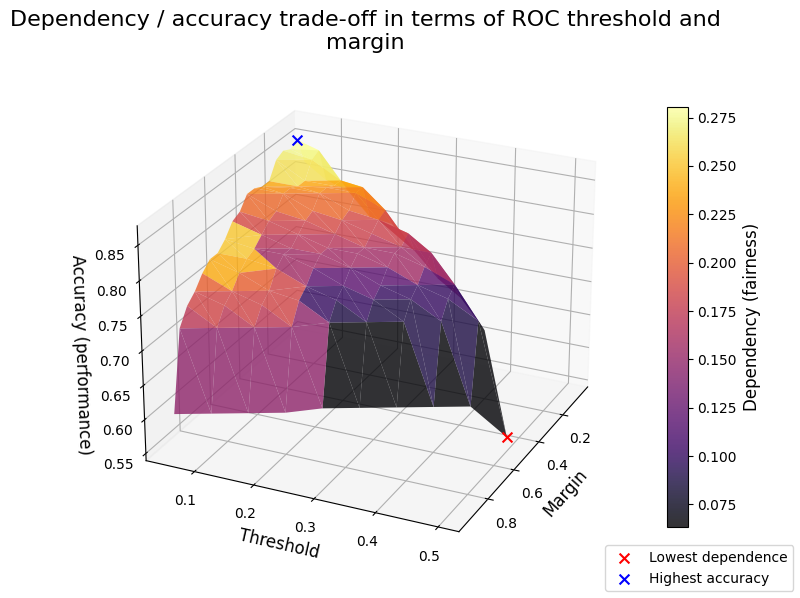

In [96]:
# get grid search threshold and margin values
credit_roc_pp = credit_ppm_roc.postprocessor_
credit_roc_res = pd.DataFrame(credit_roc_pp.cv_results_)
credit_roc_t = credit_roc_res['param_threshold']
credit_roc_m = credit_roc_res['param_margin']

# ROC postprocessing without grid search
credit_ppm_trade = PostProcessingMeta(
    credit_ppm_roc.estimator,
    RejectOptionClassifier('LatinoEthnicity'),
    random_state=0
).fit(credit_X_train, credit_y_train)

# dependency and accuracy results
credit_roc_dep = np.zeros(credit_roc_t.shape)
credit_roc_acc = np.zeros(credit_roc_t.shape)

# fit, predict and score for each threshold and margin
for i, (t, m) in enumerate(zip(credit_roc_t, credit_roc_m)):
    credit_ppm_trade.set_params(
        postprocessor__threshold=t,
        postprocessor__margin=m
    )
    y_pred = credit_ppm_trade.fit(credit_X_train, credit_y_train).predict(credit_X_test)
    credit_roc_dep[i] = fairness_dependence_metric(credit_X_test['Ethnicity'], y_pred, 'Latino', 1)
    credit_roc_acc[i] = 1 - mean_absolute_error(credit_y_test, y_pred)

# best dependency and accuracy
credit_roc_dep_best_i = np.argmin(credit_roc_dep)
credit_roc_acc_best_i = np.argmax(credit_roc_acc)


fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection='3d', computed_zorder=False))

# 4D triangulated plot
trisurf = ax.plot_trisurf(
    credit_roc_t,
    credit_roc_m,
    credit_roc_acc,
    cmap='inferno',
    alpha=0.8,
    zorder=1
)

# get colors
triangles = tri.Triangulation(
    credit_roc_t,
    credit_roc_m
).triangles
colors = credit_roc_dep.take(triangles).max(axis=1)
trisurf.set_array(colors)

# color bar
cbar = fig.colorbar(trisurf, shrink=0.8)
cbar.set_label('Dependency (fairness)', fontsize=12)

# best dependency
ax.scatter(
    credit_roc_t[credit_roc_dep_best_i],
    credit_roc_m[credit_roc_dep_best_i],
    credit_roc_acc[credit_roc_dep_best_i],
    c='r',
    s=50,
    marker='x',
    label='Lowest dependence',
    zorder=2
)
# best performance
ax.scatter(
    credit_roc_t[credit_roc_acc_best_i],
    credit_roc_m[credit_roc_acc_best_i],
    credit_roc_acc[credit_roc_acc_best_i],
    c='b',
    s=50,
    marker='x',
    label='Highest accuracy',
    zorder=2
)

# axes indicators and more
ax.set_xlabel('Margin', fontsize=12)
ax.set_ylabel('Threshold', fontsize=12)
ax.set_zlabel('Accuracy (performance)', fontsize=12)
ax.set_title('Dependency / accuracy trade-off in terms of ROC threshold and margin', fontsize=16, wrap=True)
fig.legend(loc='lower right')

fig.tight_layout()
ax.view_init(elev=25, azim=25)

It is clear that the lowest accuracy is at the point with complete independence and vice versa. The plot also shows that performance and fairness follow an inverse trend. Another important note is that we could choose a threshold and margin within certain acceptable bounds of dependency. This way we can get much better performance.

### 7 Further improvements to fairness
The final model yields complete independence between the protected ethnicity group and credit card approval. Admittedly, at a severe performance penalty. Also, it might introduce unfairness in other regards. In fact. From the predicted approval rate plots it seems that Asians got penalized the most. Black people still seem to be favored, just as in the initial dataset. This might not be desirable. It raises an important problem with the statistical parity fairness notion. Striving for equal opportunities with this notion does not require the best of the (non-)protected subgroups. While maximizing overall performance does influence this, it does not take into account how accurate each group is represented. As a result, Dwork et al. (2012) concluded that statistical parity is not sufficient as a fairness notion. Instead, a more appropriate fairness notion than statistical parity: **fairness through awareness**. As opposed to statistical parity, fairness through awareness is an individual fairness notion: it does not look at a sensitive property in particular. Individual fairness is satisfied when similar individuals are classified similarly, in proportion to their degree of similarity (Dwork et al. 2012).

### 8 Conclusion
In this work, we introduced fairness and the notion of statistical parity. The dependence metric was used to quantify statistical parity fairness. We looked at bad and good methods of improving fairness with respect to statistical parity. From our empirical results, we conclude that statistical parity can be approached with very little performance penalty (reweighing). We observed that there is trade-off performance for fairness (ROC postprocessing). A bad performance on the training set does not mean an inaccurate model ($E_{\text{in}}$ could be high due to bias, while $E_{\text{out}}$ is low) However, recent literature is moving towards individual fairness, as group fairness notions are not always as fair as they should.

## References
* Agarwal, A., Dudík, M., & Wu, Z. S. (2019, May). Fair regression: Quantitative definitions and reduction-based algorithms. In *International Conference on Machine Learning (pp. 120-129)*. PMLR.
* Barocas, S., Hardt, M., & Narayanan, A. (2017). Fairness in machine learning. Nips tutorial, 1, 2017.
* Calders, T., Kamiran, F., & Pechenizkiy, M. (2009, December). Building classifiers with independency constraints. In *2009 IEEE international conference on data mining workshops* (pp. 13-18). IEEE.
* Chouldechova, A., & Roth, A. (2018). The frontiers of fairness in machine learning. *arXiv preprint arXiv:1810.08810*.
* Chzhen, E. (2022). *Algorithmic Fairness : regression with demographic parity constraints* (slides) [https://www.dataia.eu/sites/default/files/Documents/Chzhen_slides22June.pdf].
* Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
* Dwork, C., Hardt, M., Pitassi, T., Reingold, O., & Zemel, R. (2012, January). Fairness through awareness. In *Proceedings of the 3rd innovations in theoretical computer science conference* (pp. 214-226).
* Imbalanced-learn. (2022) Over-sampling: SMOTE and ADASYN. [https://imbalanced-learn.org/stable/over_sampling.html#from-random-over-sampling-to-smote-and-adasyn]
* Kamiran, F., Karim, A., & Zhang, X. (2012, December). Decision theory for discrimination-aware classification. In *2012 IEEE 12th international conference on data mining (pp. 924-929)*. IEEE.
* Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions, Statistics and Probability Letters, 33 (1997) 291-297.